# E-commerce customer segmentation. 

## Segmentation modeling notebook

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Content</h3>

* [1. Problematic](#1)
* [2. Methodology](#2)    
* [3. Data preparation](#3)
  - [3.1 Importing libraries](#3.1)
  - [3.2 Data import and joins](#3.2)
  - [3.3 Feature engineering](#3.3)
* [4. Kmean on RFM features](#4)
  - [4.1 Sampling](#4.1)
  - [4.2 Testing the number of clusters](#4.2)
  - [4.3 Cluster analysis](#4.3)
* [5. Kmean on improved RFM features](#5)
  - [5.1 Sampling](#5.1)
  - [5.2 Testing the number of clusters](#5.2)
  - [5.3 Cluster analysis](#5.3)
* [6. Conclusion](#6)
* [7. Appendix](#7)
  - [7.1 DBSCAN](#7.1)
  - [7.2 Agglomerative clustering](#7.2)

<a id="1"></a>
<font color="darkslateblue" size=+2.5><b>1. Problematic</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:grey" data-toggle="popover">go to TOC</a>

Olist wishes to obtain a segmentation of its customers that can be used on a daily basis by their marketing team in their communication campaigns.
The goal is to understand different types of users through their behavior and anonymized personal data.

So here we will provide an actionable description of segmentation and its underlying logic for optimal use. We will also need to provide an analysis of the stability of the segments over time (with the aim of establishing a maintenance contract).

We will therefore use unsupervised methods to group together customers with similar profiles.

<a id="2"></a>
<font color="darkslateblue" size=+2.5><b>2. Methodology</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:grey" data-toggle="popover">go to TOC</a>

 - First we load the data in a pandas DataFrame then we aggregate the data

 - We then realise the feature engineering already studied in the client file.
    - RFM: Recency, Monetary, Frequency
    - client satisfaction : 'mean_review score'
    - payment installment : 'mean_payment_installments'
    - number of articles : 'mean_items_order'

------------------------

 - Then we test an unsupervised KMean clustering algorithm for two collection of variables : RFM alone and RFM with the three others variable combine 
    - We repeat the following process in those two occurences
        - We test the validity of sampling to facilitate processing.
        - Next we test the number of cluster and the quality of cluster
        - Finally we realise a cluster analysis with the end goal to give actionable interpretation of our cluster.
    - We will have tested other model to choose the best option


<a id="3"></a>
<font color="darkslateblue" size=+2.5><b>3. Data preparation</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:grey" data-toggle="popover">go to TOC</a>

<a id="3.1"></a>
<font color="dimgrey" size=+2.0><b>3.1 Importing libraries</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [1]:
# Import necessary libraries
import io
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.facecolor']='w'
%matplotlib inline

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [3]:
from sklearn.cluster import DBSCAN

In [4]:
from sklearn.cluster import AgglomerativeClustering

In [5]:
#!pip install threadpoolctl==3.1.0

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
import os

In [8]:
import umap

In [9]:
from P5_functions import *

<a id="3.2"></a>
<font color="dimgrey" size=+2.0><b>3.2 Data import and joins</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

#### DATA Structure

![image](https://i.imgur.com/HRhd2Y0.png)

In [10]:
#file_path = r'Olist_Dataset/'
cnx = sqlite3.connect('olist.db')

In [11]:
# Chargement des données 
customers_df = pd.read_sql_query('select * from customers', cnx).drop('index',axis = 1)
geo_df = pd.read_sql_query('select * from geoloc', cnx).drop('index',axis = 1)
orderitem_df = pd.read_sql_query('select * from order_items', cnx).drop('index',axis = 1)
orderpay_df = pd.read_sql_query('select * from order_pymts', cnx).drop('index',axis = 1)
orderreviews_df = pd.read_sql_query('select * from order_reviews', cnx).drop('index',axis = 1) 
orders_df = pd.read_sql_query('select * from orders', cnx).drop('index',axis = 1) 
products_df = pd.read_sql_query('select * from products', cnx).drop('index',axis = 1) 
sellers_df = pd.read_sql_query('select * from sellers', cnx).drop('index',axis = 1) 
categname_df = pd.read_sql_query('select * from translation', cnx).drop('index',axis = 1) 
# Change cols names before merging 
customers_df.rename(columns={"customer_zip_code_prefix": "zip_code"}, inplace=True)
geo_df.rename(columns={"geolocation_zip_code_prefix": "zip_code"}, inplace=True)

In [12]:
# Join datasets
data = orders_df.merge(customers_df, on="customer_id").merge(orderitem_df, on="order_id").merge(products_df, on="product_id").merge(categname_df, on="product_category_name").merge(orderpay_df, on="order_id").merge(sellers_df, on="seller_id").merge(orderreviews_df, on="order_id")

<a id="3.3"></a>
<font color="dimgrey" size=+2.0><b>3.3 Feature engineering</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

## RFM Analysis

In [14]:
#  Recency
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
df_recency = data.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
df_recency.rename(columns={"order_purchase_timestamp":"LastPurchaseDate"}, inplace=True)
df_recency["LastPurchaseDate"] = df_recency["LastPurchaseDate"].dt.date
# Get recent invoice date and use it to calculate recency
recent_date = data['order_purchase_timestamp'].dt.date.max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_recency.head()

customer_unique_id LastPurchaseDate  Recency
0  0000366f3b9a7992bf8c76cfdf3221e2       2018-05-10      116
1  0000b849f77a49e4a4ce2b2a4ca5be3f       2018-05-07      119
2  0000f46a3911fa3c0805444483337064       2017-03-10      542
3  0000f6ccb0745a6a4b88665a16c9f078       2017-10-12      326
4  0004aac84e0df4da2b147fca70cf8255       2017-11-14      293

In [15]:
#  frequency
frequency_df = data.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)
frequency_df.head()

customer_unique_id  Frequency
0  0000366f3b9a7992bf8c76cfdf3221e2          1
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1
2  0000f46a3911fa3c0805444483337064          1
3  0000f6ccb0745a6a4b88665a16c9f078          1
4  0004aac84e0df4da2b147fca70cf8255          1

In [16]:
#  monetary 
monetary_df = data.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']
monetary_df.head()

customer_unique_id  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19
2  0000f46a3911fa3c0805444483337064     86.22
3  0000f6ccb0745a6a4b88665a16c9f078     43.62
4  0004aac84e0df4da2b147fca70cf8255    196.89

In [17]:
# mean_payment_installments
mean_payment_installments_df = data.groupby('customer_unique_id', as_index=False)['payment_installments'].mean()
mean_payment_installments_df.columns = ['customer_unique_id', 'mean_payment_installments']
mean_payment_installments_df.head()

customer_unique_id  mean_payment_installments
0  0000366f3b9a7992bf8c76cfdf3221e2                        8.0
1  0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0
2  0000f46a3911fa3c0805444483337064                        8.0
3  0000f6ccb0745a6a4b88665a16c9f078                        4.0
4  0004aac84e0df4da2b147fca70cf8255                        6.0

In [18]:
mean_items_order_df = data.groupby('customer_unique_id', as_index=False)['order_item_id'].mean()
mean_items_order_df.columns = ['customer_unique_id', 'mean_items_order']
mean_items_order_df.head()

customer_unique_id  mean_items_order
0  0000366f3b9a7992bf8c76cfdf3221e2               1.0
1  0000b849f77a49e4a4ce2b2a4ca5be3f               1.0
2  0000f46a3911fa3c0805444483337064               1.0
3  0000f6ccb0745a6a4b88665a16c9f078               1.0
4  0004aac84e0df4da2b147fca70cf8255               1.0

In [19]:
# mean_rev_score
mean_rev_score_df = data.groupby('customer_unique_id', as_index=False)['review_score'].mean()
mean_rev_score_df.columns = ['customer_unique_id', 'mean_rev_score']
mean_rev_score_df.head()

customer_unique_id  mean_rev_score
0  0000366f3b9a7992bf8c76cfdf3221e2             5.0
1  0000b849f77a49e4a4ce2b2a4ca5be3f             4.0
2  0000f46a3911fa3c0805444483337064             3.0
3  0000f6ccb0745a6a4b88665a16c9f078             4.0
4  0004aac84e0df4da2b147fca70cf8255             5.0

In [20]:
# merging dfs
rf_df = df_recency.merge(frequency_df, on='customer_unique_id')
rfm_df = rf_df.merge(monetary_df, on='customer_unique_id').drop(columns='LastPurchaseDate')
New_feat_df = rfm_df.merge(mean_payment_installments_df, on='customer_unique_id').merge(mean_rev_score_df, on='customer_unique_id').merge(mean_items_order_df, on='customer_unique_id')
New_feat_df.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   mean_payment_installments  mean_rev_score  mean_items_order  
0                        8.0             5.0               1.0  
1                        1.0             4.0               1.0  
2                        8.0             3.0               1.0  
3                        4.0             4.0               1.0  
4                        6.0             5.0               1.0

In [21]:
# Let's check if data is skewed first
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

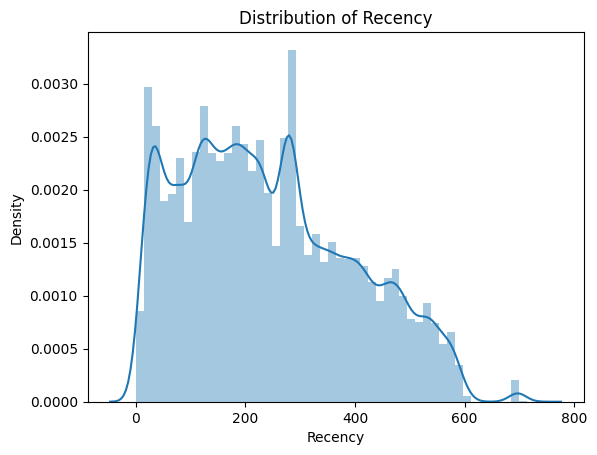

Recency's: Skew: 0.4525739019900252, : SkewtestResult(statistic=53.917503973361256, pvalue=0.0)


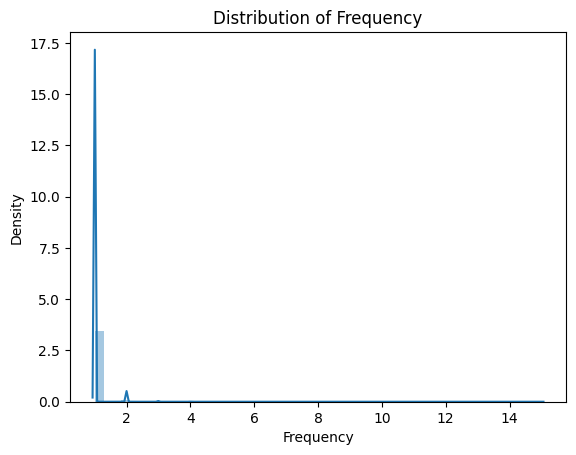

Frequency's: Skew: 10.990942154921314, : SkewtestResult(statistic=335.6456861541721, pvalue=0.0)


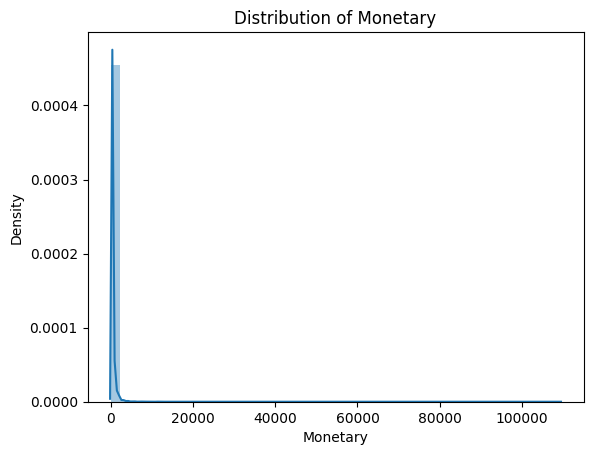

Monetary's: Skew: 70.33621193560055, : SkewtestResult(statistic=524.6379205104615, pvalue=0.0)


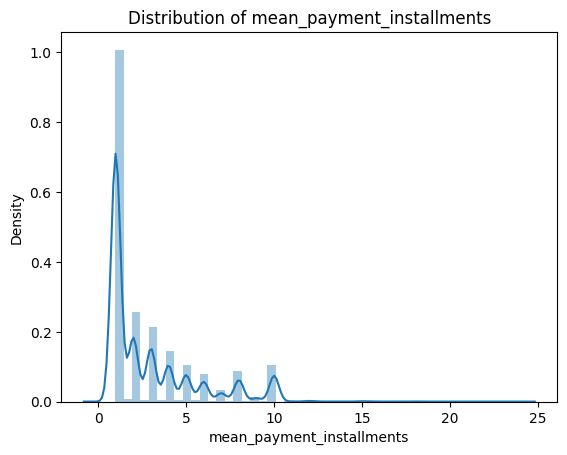

mean_payment_installments's: Skew: 1.605425910346985, : SkewtestResult(statistic=145.53164726580053, pvalue=0.0)


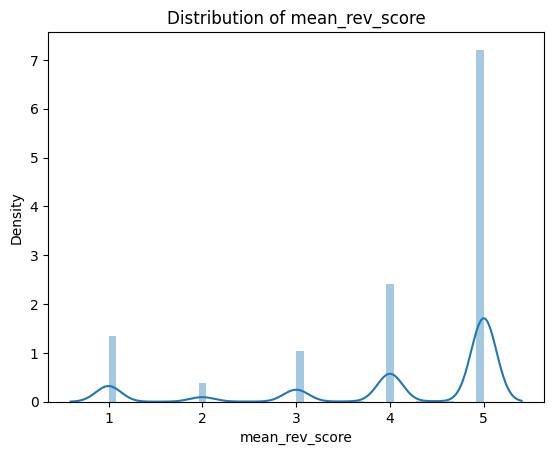

mean_rev_score's: Skew: -1.3936377857797562, : SkewtestResult(statistic=-132.88292661467767, pvalue=0.0)


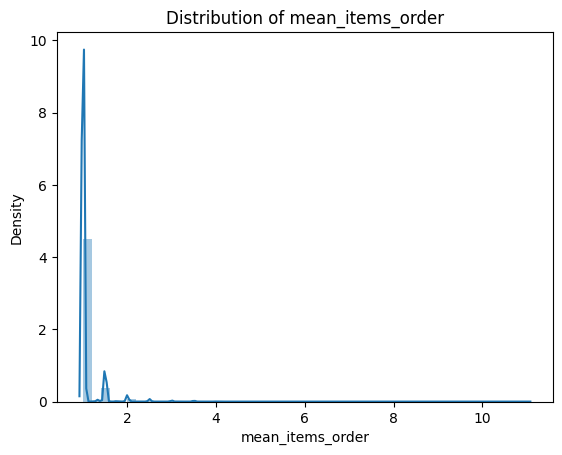

mean_items_order's: Skew: 7.326352842384715, : SkewtestResult(statistic=294.49455927256474, pvalue=0.0)


In [22]:
for col in New_feat_df.columns[1:]:
    check_skew(New_feat_df, col)

In [23]:
# Remove zeros from data before log trans
New_feat_df[New_feat_df.columns[1:]] = New_feat_df[New_feat_df.columns[1:]].applymap(lambda x: 1 if x ==0 else x)

In [24]:
#  log transformation 
New_feat_df_log = New_feat_df.copy()
New_feat_df_log['Monetary'] = np.log10(New_feat_df_log['Monetary'])

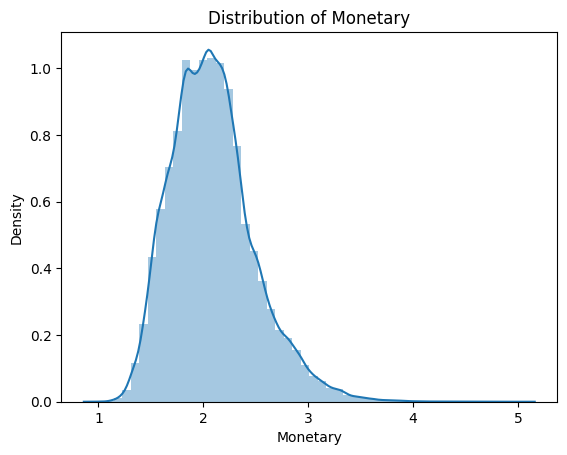

Monetary's: Skew: 0.729609897634013, : SkewtestResult(statistic=81.9204555191681, pvalue=0.0)


In [25]:
check_skew(New_feat_df_log, 'Monetary')

In [26]:
New_feat_df_log = New_feat_df_log.set_index('customer_unique_id')

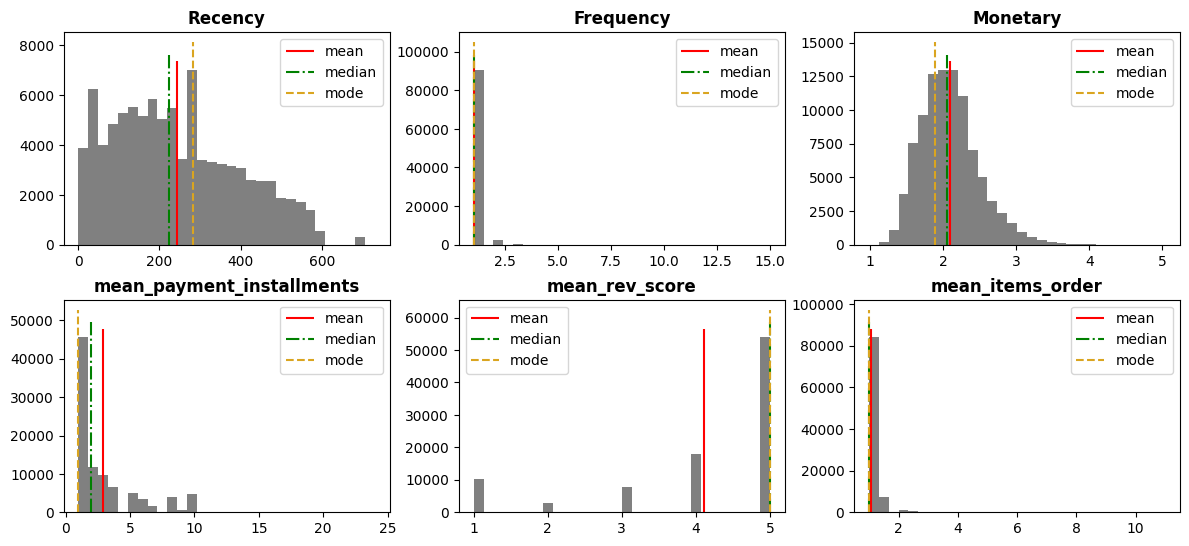

In [27]:
plot_histograms(df=New_feat_df_log, cols=New_feat_df_log.columns,
                figsize=(12,8), bins=30, layout=(3,3))

<a id="4"></a>
<font color="darkslateblue" size=+2.5><b>4. Kmean on RFM features</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:grey" data-toggle="popover">go to TOC</a>

In [28]:
RFM_Table = New_feat_df_log[['Recency','Frequency','Monetary']].copy()

In [29]:
# data scaling
scaler = StandardScaler()
#scaler.fit(rfm_df_log)
RFM_Table_scaled = pd.DataFrame(scaler.fit_transform(RFM_Table) , index = RFM_Table.index , columns=RFM_Table.columns)

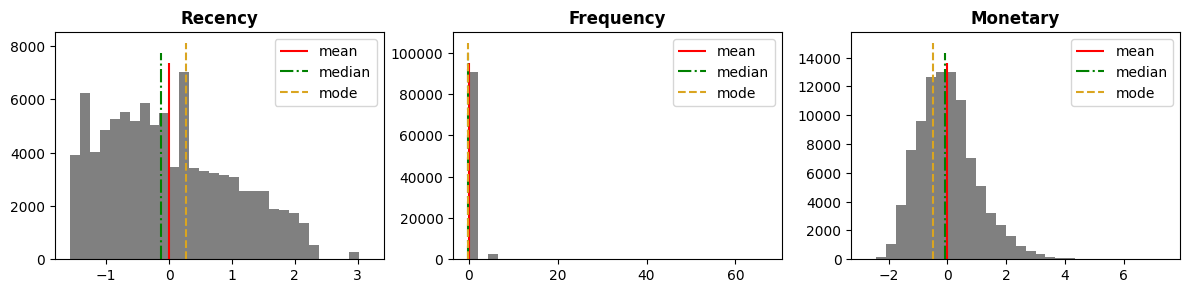

In [30]:
plot_histograms(df=RFM_Table_scaled, cols=RFM_Table_scaled.columns,
                figsize=(12,8), bins=30, layout=(3,3))

<a id="4.1"></a>
<font color="dimgrey" size=+2.0><b>4.1 Sampling</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [31]:
# We test the validity of sampling to facilitate processing.

In [32]:
# Choosing a model
km_sampl = KMeans(n_clusters=4, init='k-means++', n_init='auto', random_state = 14)
km_sampl.fit(RFM_Table_scaled)

KMeans(n_clusters=4, n_init='auto', random_state=14)

In [33]:
n_iter=10 #10
li_n_samp = [100, 250, 500, 750, 1000, 2000, 3000,
             4000, 5000, 7500, 10000, 20000, 50000]

df_ARI_all_vs_sample_iter = \
    check_ARI_through_sampling(km_sampl, RFM_Table_scaled, li_n_samp,
                               n_iter=n_iter)

ooo ITERATION 0 ooo
ooo ITERATION 1 ooo
ooo ITERATION 2 ooo
ooo ITERATION 3 ooo
ooo ITERATION 4 ooo
ooo ITERATION 5 ooo
ooo ITERATION 6 ooo
ooo ITERATION 7 ooo
ooo ITERATION 8 ooo
ooo ITERATION 9 ooo


In [34]:
# Showing a summary of the ARI scores through iterations
pd.concat([df_ARI_all_vs_sample_iter.mean(1),
           df_ARI_all_vs_sample_iter.std(1), df_ARI_all_vs_sample_iter],
          axis=1).rename(columns={0:'mean', 1: 'std'})

mean           std    iter_0    iter_1    iter_2  \
[all, 100_sampl]    0.449062  1.170278e-16  0.449062  0.449062  0.449062   
[all, 250_sampl]    0.925065  0.000000e+00  0.925065  0.925065  0.925065   
[all, 500_sampl]    0.959357  0.000000e+00  0.959357  0.959357  0.959357   
[all, 750_sampl]    0.883486  2.340556e-16  0.883486  0.883486  0.883486   
[all, 1000_sampl]   0.955842  1.170278e-16  0.955842  0.955842  0.955842   
[all, 2000_sampl]   0.875387  0.000000e+00  0.875387  0.875387  0.875387   
[all, 3000_sampl]   0.969418  0.000000e+00  0.969418  0.969418  0.969418   
[all, 4000_sampl]   0.957240  1.170278e-16  0.957240  0.957240  0.957240   
[all, 5000_sampl]   0.952179  1.170278e-16  0.952179  0.952179  0.952179   
[all, 7500_sampl]   0.979497  0.000000e+00  0.979497  0.979497  0.979497   
[all, 10000_sampl]  0.978042  1.170278e-16  0.978042  0.978042  0.978042   
[all, 20000_sampl]  0.957133  1.170278e-16  0.957133  0.957133  0.957133   
[all, 50000_sampl]  0.994627  0.000000e+00  0.994627  0.994627  0.994627   

                      iter_3    iter_4    iter_5    iter_6    iter_7  \
[all, 100_sampl]    0.449062  0.449062  0.449062  0.449062  0.449062   
[all, 250_sampl]    0.925065  0.925065  0.925065  0.925065  0.925065   
[all, 500_sampl]    0.959357  0.959357  0.959357  0.959357  0.959357   
[all, 750_sampl]    0.883486  0.883486  0.883486  0.883486  0.883486   
[all, 1000_sampl]   0.955842  0.955842  0.955842  0.955842  0.955842   
[all, 2000_sampl]   0.875387  0.875387  0.875387  0.875387  0.875387   
[all, 3000_sampl]   0.969418  0.969418  0.969418  0.969418  0.969418   
[all, 4000_sampl]   0.957240  0.957240  0.957240  0.957240  0.957240   
[all, 5000_sampl]   0.952179  0.952179  0.952179  0.952179  0.952179   
[all, 7500_sampl]   0.979497  0.979497  0.979497  0.979497  0.979497   
[all, 10000_sampl]  0.978042  0.978042  0.978042  0.978042  0.978042   
[all, 20000_sampl]  0.957133  0.957133  0.957133  0.957133  0.957133   
[all, 50000_sampl]  0.994627  0.994627  0.994627  0.994627  0.994627   

                      iter_8    iter_9  
[all, 100_sampl]    0.449062  0.449062  
[all, 250_sampl]    0.925065  0.925065  
[all, 500_sampl]    0.959357  0.959357  
[all, 750_sampl]    0.883486  0.883486  
[all, 1000_sampl]   0.955842  0.955842  
[all, 2000_sampl]   0.875387  0.875387  
[all, 3000_sampl]   0.969418  0.969418  
[all, 4000_sampl]   0.957240  0.957240  
[all, 5000_sampl]   0.952179  0.952179  
[all, 7500_sampl]   0.979497  0.979497  
[all, 10000_sampl]  0.978042  0.978042  
[all, 20000_sampl]  0.957133  0.957133  
[all, 50000_sampl]  0.994627  0.994627

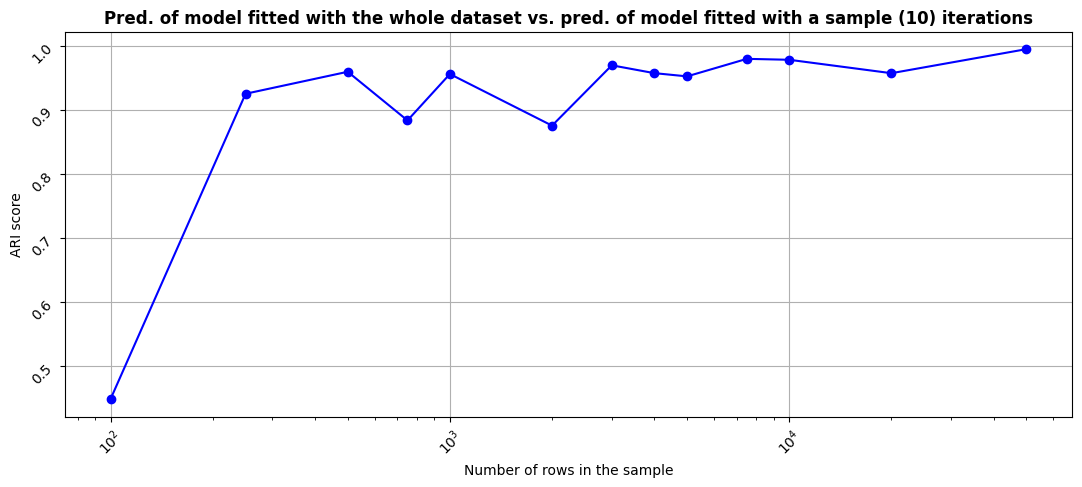

In [35]:
# Plotting the results

fig, ax = plt.subplots(1)
fig.set_size_inches(13,5)

ax.errorbar(li_n_samp,
            df_ARI_all_vs_sample_iter.mean(1).values,
            yerr=2*(df_ARI_all_vs_sample_iter.std(1).values),
            marker='o', color='blue')

ax.tick_params(rotation=45)
ax.set_xscale('log')
plt.xlabel("Number of rows in the sample")
plt.ylabel("ARI score")
plt.title(f"Pred. of model fitted with the whole dataset \
vs. pred. of model fitted with a sample ({n_iter}) iterations", fontweight='bold')
plt.grid()
plt.show()

We can consider that a model fitted on a stratified sample of 5000 gives similar results as a model fitted on the whole dataset (ARI greater than 0.90)

In [36]:
df_sampl, _ = train_test_split( RFM_Table_scaled, train_size=5000)
ind_sampl = df_sampl.index

In [37]:
RFM_Table_scaled = RFM_Table_scaled.loc[ind_sampl]
df_expl = RFM_Table.loc[ind_sampl]

<a id="4.2"></a>
<font color="dimgrey" size=+2.0><b>4.2 Testing the number of clusters</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

#### Evaluation of the KMeans clustering scores

We'll try to find the best number of cluster against:

- **Silhouette score**: measures the difference between the intra-cluster and nearest-cluster mean square distances (to maximize)
- **Davies_Bouldin score**: measures the maximal ratio of dispersion of pairs of clusters to their distance (to minimize)
- **Calinski_Harabasz score**: the ratio of inter-cluster dispersion to intra-cluster dispersion (to maximize)
- **Distortion**: the mean sum of squared distances to centers (find an elbow)

NB: the error bar represents 2 times the standard deviation (+/- 2 sigma)

In [38]:
%%time

import dill

# If the results are not existing (pickle) then recomputes
# Returns:
# - the aggregated results (mean, median, std) of the 4 scores
# - the list of the clusters predicted for each iteration and number of clusters
# - the proportion (pct) of the clusters 

list_n_clust = range(3,7)
n_iter = 20
dict_scores_iter, dict_ser_clust_n_clust, dict_pop_perc_n_clust = \
                    compute_clust_scores_nclust(RFM_Table_scaled,
                                                list_n_clust=list_n_clust,
                                                n_iter=n_iter,
                                                return_pop=True)

CPU times: total: 1min 15s
Wall time: 33.5 s


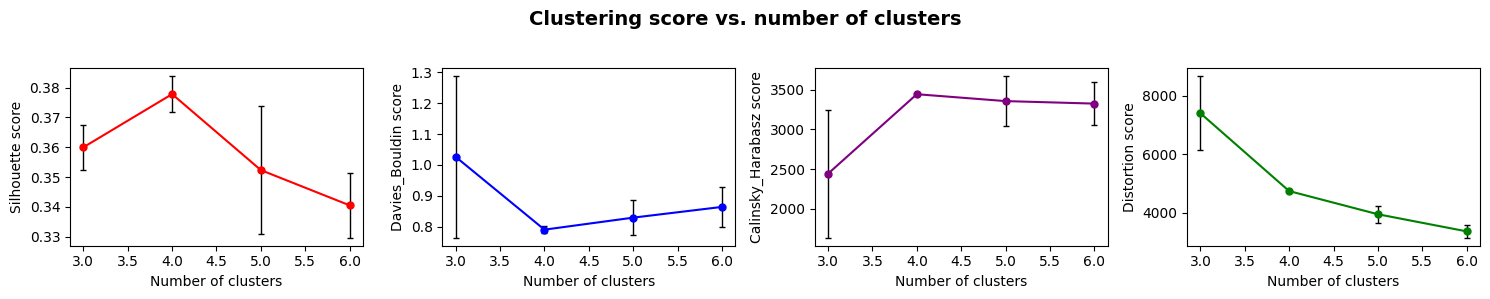

In [39]:
plot_scores_vs_n_clust(dict_scores_iter, figsize=(15,3))

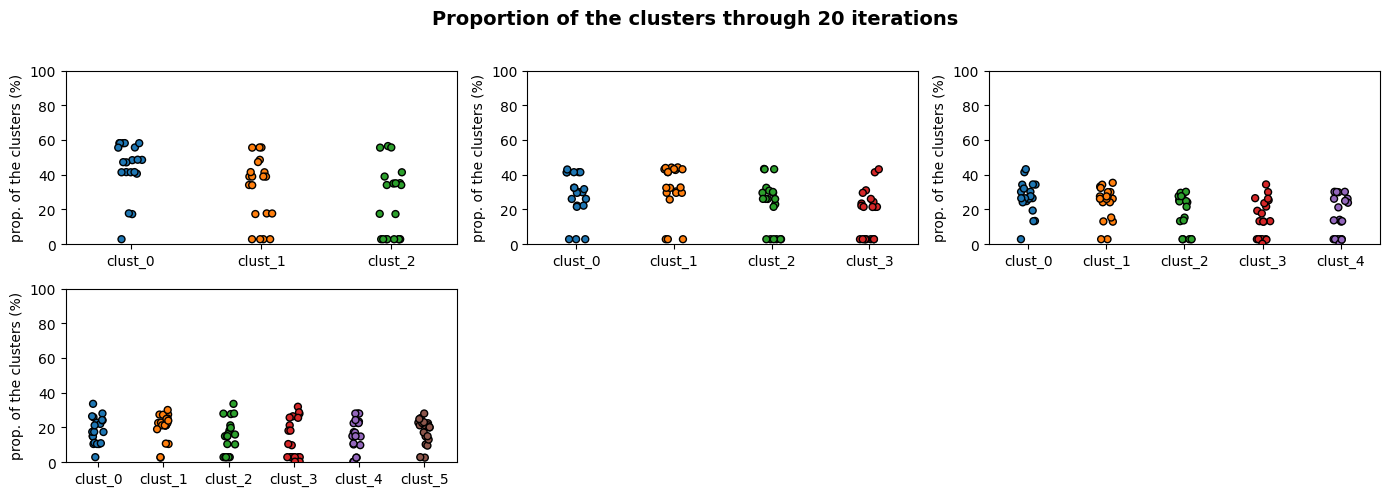

In [40]:
plot_prop_clust_vs_nclust(dict_pop_perc_n_clust, figsize=(14,7))

#### Silhouette scores of each cluster

Let's now see in more details the silhouette scores of each cluster, for the different number of clusters.

On the left part of the graph, the silhouette coefficient is plotted for each number of clusters:
- the length of the bands is proportionnal to the size of the cluster
- the width of the small bars are the distance of each point to the closest centroid

On the right a representation of the clusters on UMAP projection of the data.

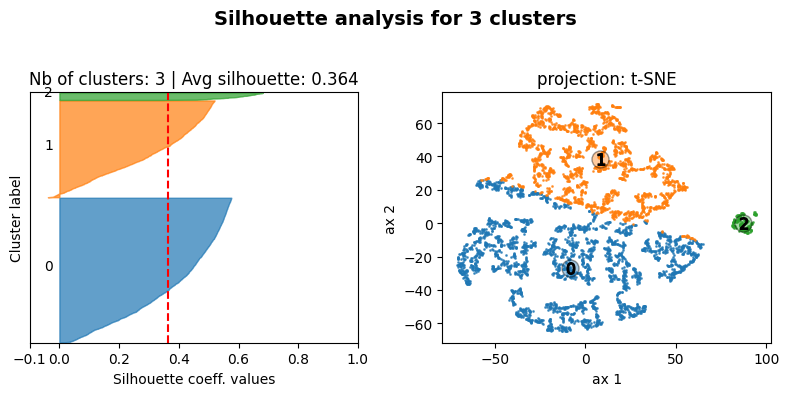

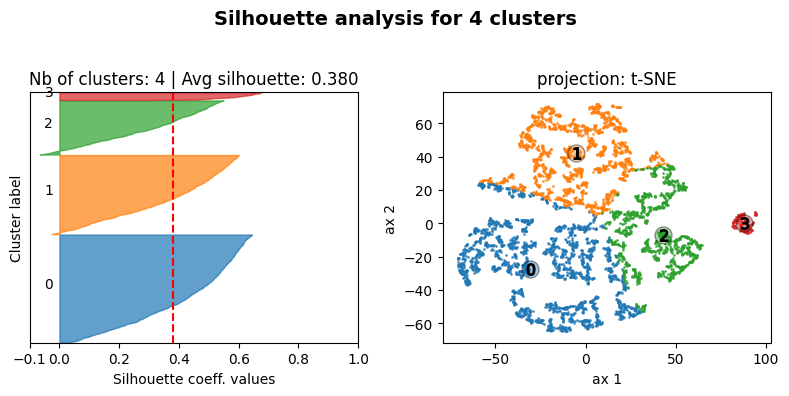

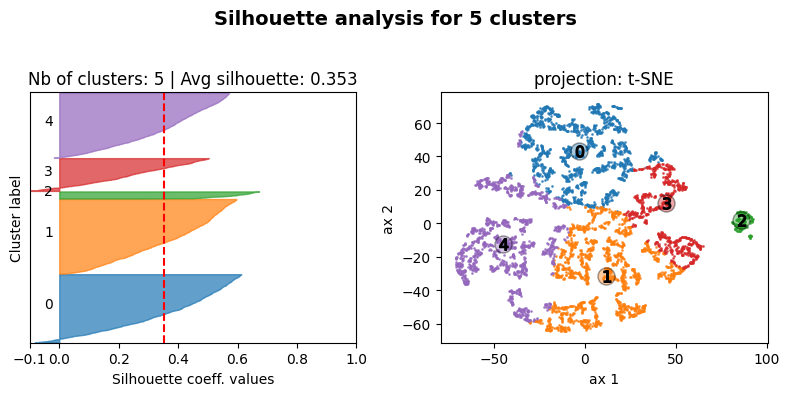

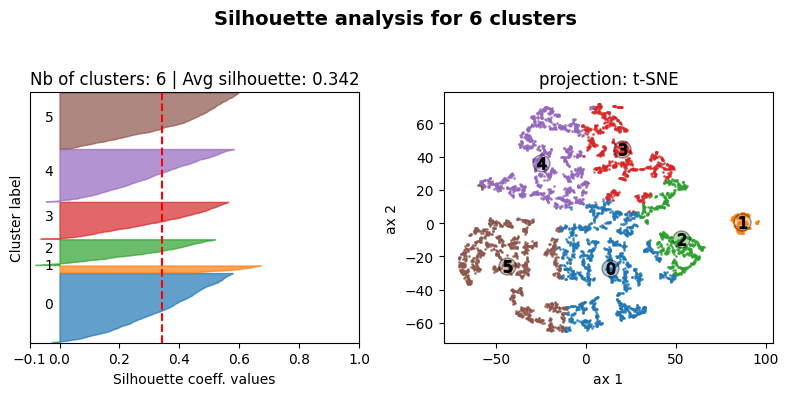

CPU times: total: 9min 6s
Wall time: 1min 26s


In [41]:
%%time

silh_scores_vs_n_clust(RFM_Table_scaled, n_clust=list_n_clust, proj='t-SNE',
                       xlim=(-0.1,1), figsize=(8,4),
                       palette='tab10')

In [42]:
df_ARI_stab = pd.DataFrame()
for i in list_n_clust:
    print("ooooooooo Number of clusters: ", i)
    stab_init_kmeans = ARI_column_pairs(dict_ser_clust_n_clust[i],
                                        first_vs_others=False)
    df_ARI_stab = pd.concat([df_ARI_stab, stab_init_kmeans.to_frame()], axis=1)

ooooooooo Number of clusters:  3
--- ARI all 190 unique pairs ---
ARI: mean=0.809, std=0.143, min=0.612, max=1.000 
ooooooooo Number of clusters:  4
--- ARI all 190 unique pairs ---
ARI: mean=0.834, std=0.118, min=0.664, max=1.000 
ooooooooo Number of clusters:  5
--- ARI all 190 unique pairs ---
ARI: mean=0.613, std=0.249, min=0.358, max=1.000 
ooooooooo Number of clusters:  6
--- ARI all 190 unique pairs ---
ARI: mean=0.586, std=0.224, min=0.313, max=1.000 


In [43]:
df_ARI_stab.sample(3)

ARI_3_clust_all_pairs  ARI_4_clust_all_pairs  \
[iter_6, iter_11]               1.000000               0.769888   
[iter_5, iter_18]               0.996113               0.755024   
[iter_3, iter_17]               0.867355               0.793893   

                   ARI_5_clust_all_pairs  ARI_6_clust_all_pairs  
[iter_6, iter_11]               0.389298               0.583289  
[iter_5, iter_18]               0.393498               0.415164  
[iter_3, iter_17]               0.486838               0.447267

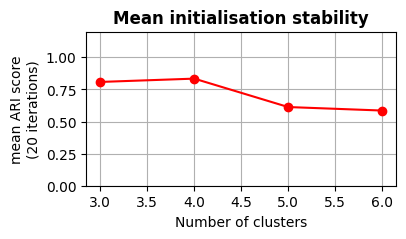

In [44]:
fig, ax = plt.subplots(1)
fig.set_size_inches(4,2)
ax.plot(list_n_clust, df_ARI_stab.mean(), '-or')
ax.set_xlabel('Number of clusters')
ax.set_ylabel(f'mean ARI score\n({n_iter} iterations)')
ax.set(ylim=(0.0,1.2))
ax.grid()
plt.title('Mean initialisation stability', fontweight='bold')
plt.show()

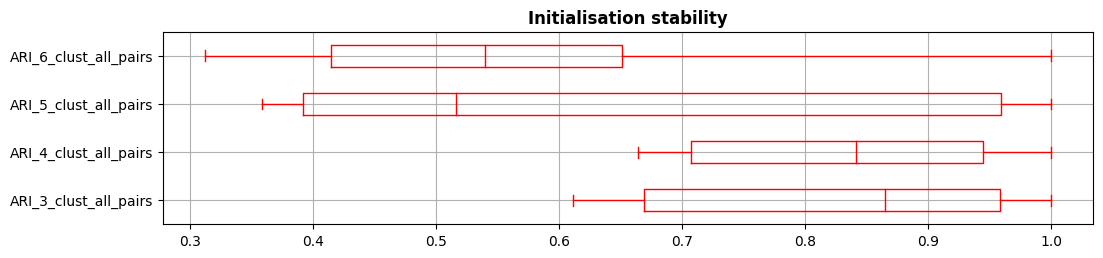

In [45]:
df_ARI_stab.boxplot(color='red', vert=False)
plt.gcf().set_size_inches(12,2.5)
plt.title('Initialisation stability', fontweight='bold')
plt.show()

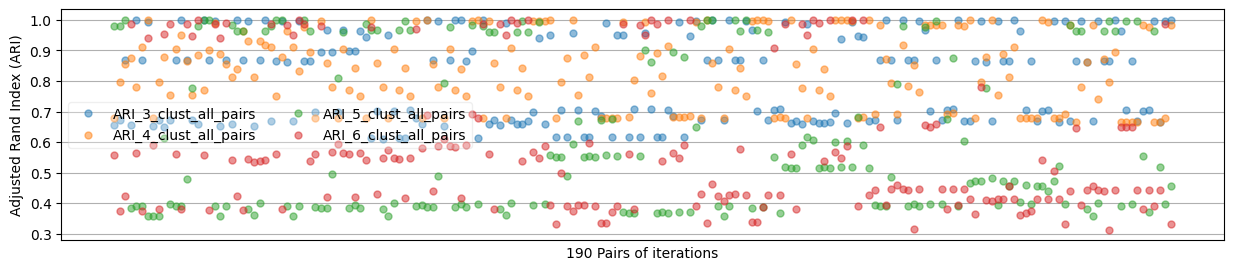

In [46]:
fig, ax = plt.subplots(1)
df_ARI_stab.plot(marker='o', markersize=5, linestyle='', alpha=0.5, ax=ax)
fig.set_size_inches(15,3)
ax.legend(ncol=2).get_frame().set_alpha(0.3)
ax.set_ylabel('Adjusted Rand Index (ARI)')
ax.set_xlabel(f'{df_ARI_stab.shape[0]} Pairs of iterations')
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.grid(axis='y')
plt.show()

<a id="4.3"></a>
<font color="dimgrey" size=+2.0><b>4.3 Cluster Analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

We'll analyse the composition of the clusters given by the best model above fitted.

#### Visualisation of the best clusters

In [47]:
# fit the model on the whole dataframe

n_clust = 4
best_model = KMeans(n_clusters=n_clust,init='k-means++', n_init='auto', random_state=14) #n_jobs deprecated
best_model.fit(RFM_Table_scaled)
ser_clust = pd.Series(data=best_model.labels_,
                      index=RFM_Table_scaled.index)

silh = silhouette_score(X=RFM_Table_scaled, labels=ser_clust)
dav_bould = davies_bouldin_score(X=RFM_Table_scaled, labels=ser_clust)
cal_harab = calinski_harabasz_score(X=RFM_Table_scaled, labels=ser_clust)
distor = best_model.inertia_
silh, cal_harab, dav_bould, distor

(0.38122479987003555,
 3439.6730651511057,
 0.7849442106556517,
 4742.651014615383)

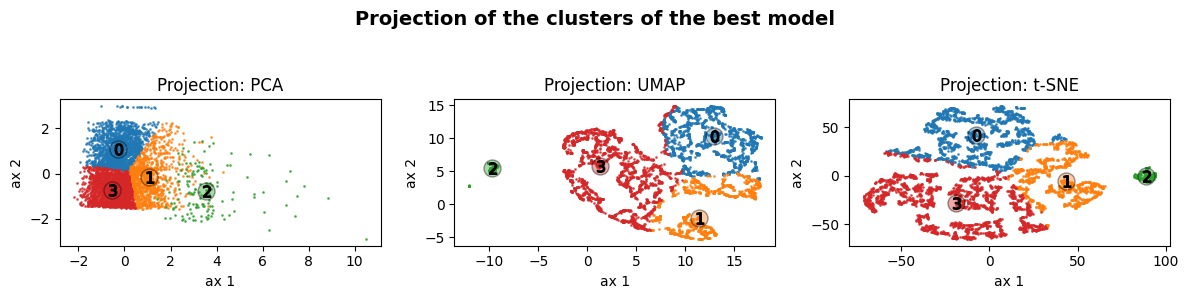

In [48]:
fig = plt.figure(figsize=(12,3))

tab_proj = ['PCA', 'UMAP', 't-SNE']
for i, proj in enumerate(tab_proj,1):
    ax = fig.add_subplot(1,len(tab_proj), i)
    # plot only a sample, but using the model already fitted
    plot_projection(RFM_Table_scaled, model=best_model, proj=proj,
                    fig=fig, ax=ax)

fig.suptitle("Projection of the clusters of the best model",
            fontweight='bold', fontsize=14)
fig.tight_layout(rect=[0,0,1,0.92])
plt.show()

#### Contingency table, Chi square scores (clusters vs. binarized features)

In [49]:
df = RFM_Table_scaled

In [50]:
# récuperer rfm_df avant le standard scaler.

In [51]:
best_model.fit(df)
ser_clust = pd.Series(best_model.labels_,
                        index=df.index,
                        name='clust')
df_expl_quant = df_expl.select_dtypes(include=[np.number])
ser_bin = pd.qcut(df_expl_quant[df_expl_quant.columns[0]],
                  [0,0.2,0.4,0.6,0.8,1],
                  precision=2, duplicates='drop')


data_crosstab = pd.crosstab(ser_clust, ser_bin, margins = False)

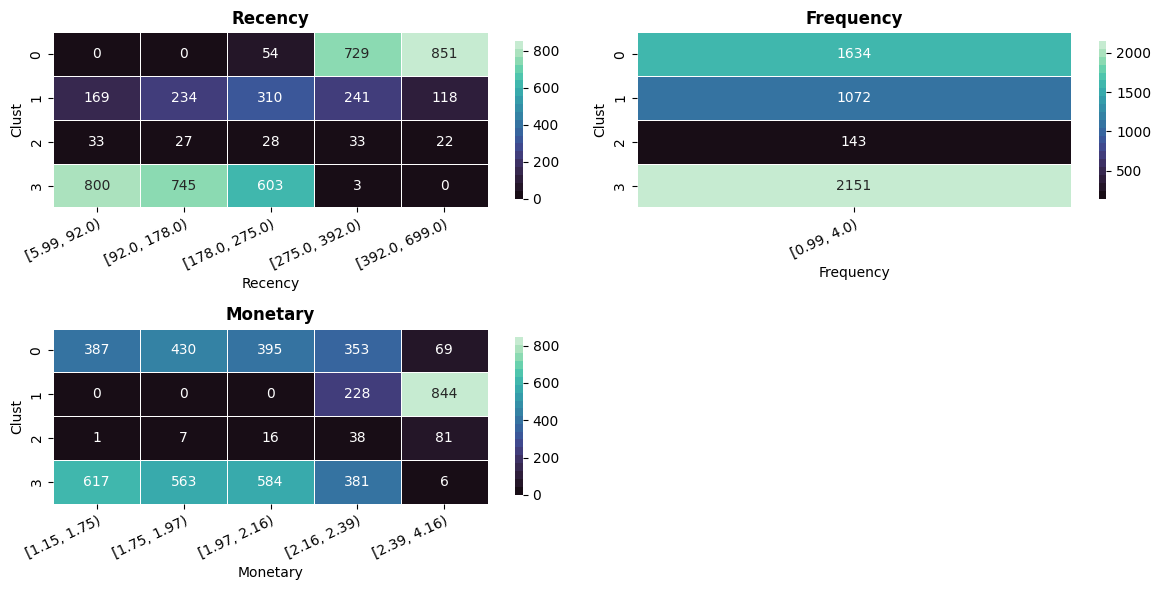

In [52]:
contingency_tables(best_model, df, df_expl, palette="mako",
                   cut_mode='quantile')

#### Relative difference of the mean

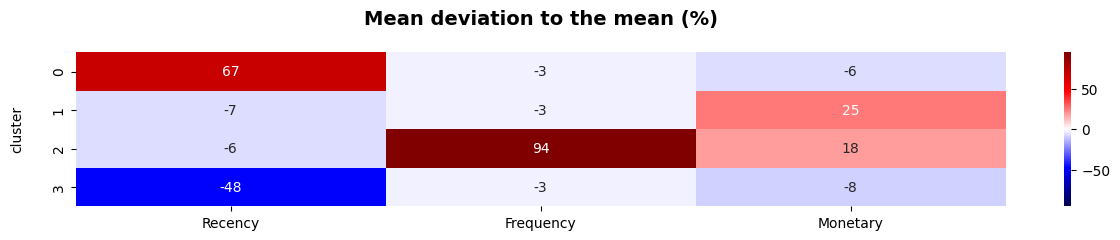

In [53]:
clust_mean, orig_df_mean, rel_var = mean_deviation_clust(best_model, df,
                                                         df_expl.loc[df.index],
                                                         palette='seismic',
                                                         figsize=(15,2))

#### Boxplots and histograms

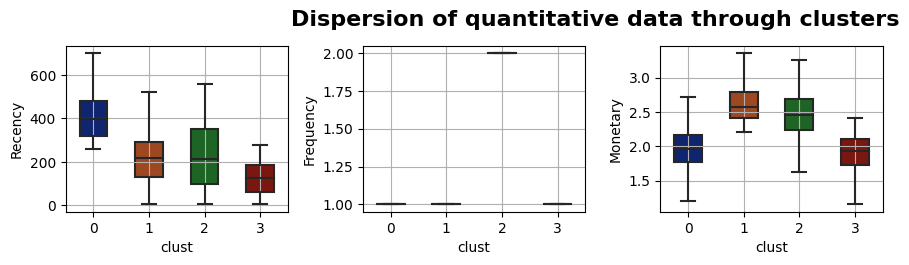

In [54]:
plot_dist_plots_feat_vs_clust(df, df_expl, best_model, layout=(3,4),
                              figsize=(12,7))

#### Radar charts

In [55]:
ser_clust = best_model.labels_
ser_mean = df_expl.mean()
ser_median = df_expl.median()

# DataFrame with the values of each columns for each cluster centroid
df_centroids = pd.DataFrame(best_model.cluster_centers_,
                            index=pd.Index(range(best_model.cluster_centers_.shape[0]),
                                           name='clust'),
                            columns=df.columns)

# DataFrame with the means of each columns for each cluster
df_clust = df_expl.assign(clust=ser_clust)\
    .reindex(columns=['clust']+list(df_expl.columns))
df_clust_mean = df_clust.groupby('clust').mean()

# DataFrame with the medians of each columns for each cluster
df_clust = df_expl.assign(clust=ser_clust)\
    .reindex(columns=['clust']+list(df_expl.columns))
df_clust_median = df_clust.groupby('clust').median()

display(df_clust_mean, df_clust_median, df_centroids)

Recency  Frequency  Monetary
clust                                 
0      406.084455   1.000000  1.959564
1      226.428172   1.000000  2.635541
2      226.797203   2.104895  2.493409
3      127.225012   1.000000  1.905417

Recency  Frequency  Monetary
clust                              
0        398.0        1.0  1.966517
1        217.0        1.0  2.577515
2        216.0        2.0  2.448258
3        127.0        1.0  1.929572

Recency  Frequency  Monetary
clust                               
0      1.064064  -0.160426 -0.322595
1     -0.098256  -0.160426  1.382652
2     -0.103471   5.145606  1.020751
3     -0.755243  -0.160426 -0.449591

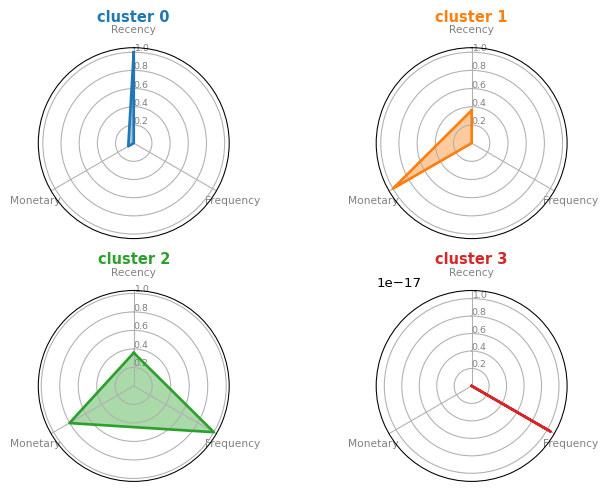

In [56]:
### CENTROIDS
#########################

my_dpi = 96

n_row = (n_clust+1)//2
fig = plt.figure(figsize=(n_row*350/my_dpi, 500/my_dpi),
                dpi=my_dpi)

# Create a color palette:
my_palette = plt.get_cmap("tab10")

# # Loop to plot
for i, row in enumerate(df_centroids.index, 1):
    ax = fig.add_subplot(2, n_row ,i, polar=True)
    plot_radar_chart(df_centroids, row,
                     title='cluster '+str(row),
                     color=my_palette(row),
                     min_max_scaling=True, ax=ax)
plt.tight_layout()

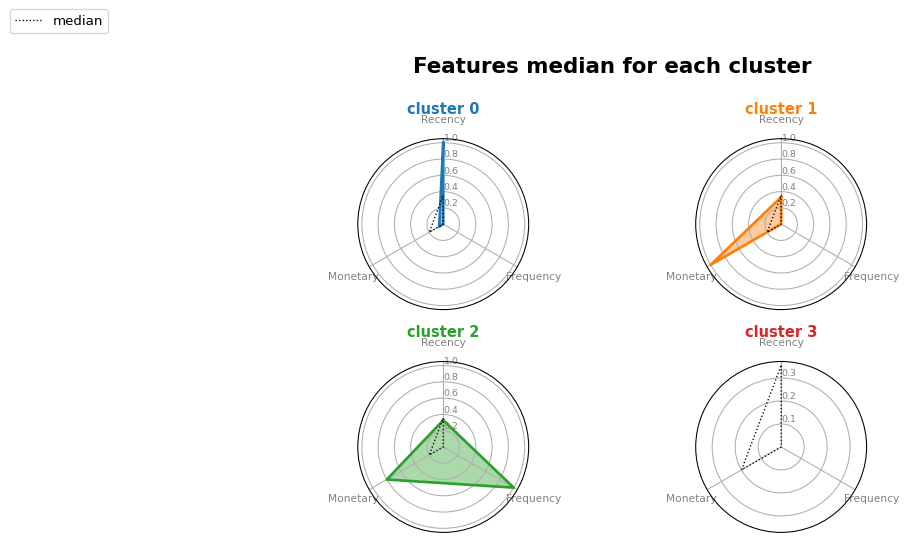

In [57]:
### MEDIAN UNTRANSFORMED DATA
###########################

my_dpi = 96

n_row = (n_clust+1)//2
fig = plt.figure(figsize=(n_row*350/my_dpi, 500/my_dpi),
                dpi=my_dpi)

# Loop to plot
for i, row in enumerate(df_clust_mean.index, 1):
    ax = fig.add_subplot(2,n_row,i, polar=True)
    plot_radar_chart(df_clust_median, row=row, #ser_mean=ser_mean,
                      ser_median=ser_median,
                     title='cluster '+str(row),
                     color=my_palette(row),
                     min_max_scaling=True, ax=ax)
plt.tight_layout(rect=[0,0,1,0.92]) # 
plt.suptitle("Features median for each cluster", fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(-3.4,3.1), ncol=2)
plt.show()

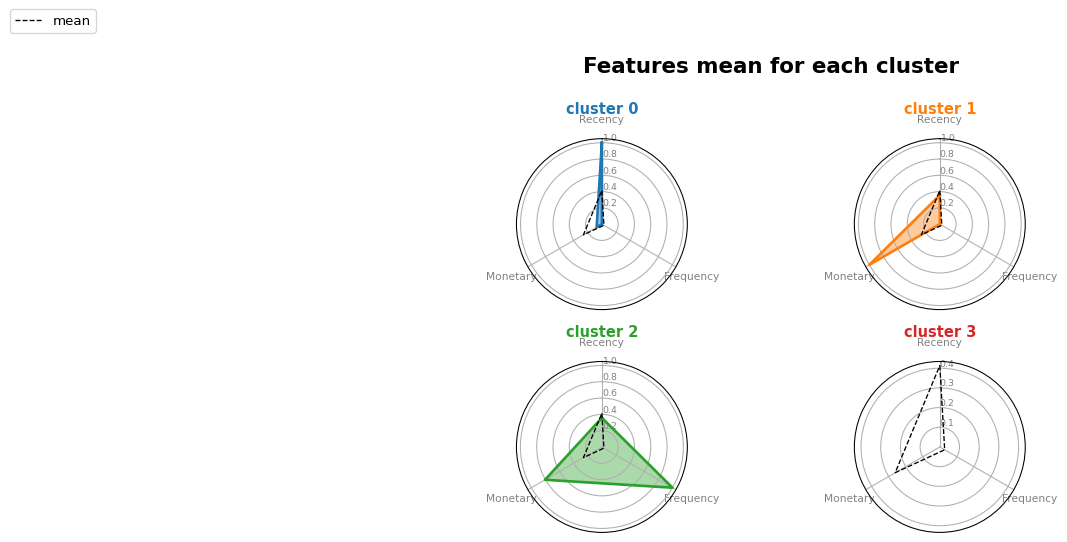

In [58]:
### MEAN UNTRANSFORMED DATA
###########################

my_dpi = 96

n_row = (n_clust+1)//2
fig = plt.figure(figsize=(n_row*350/my_dpi, 500/my_dpi),
                dpi=my_dpi)

# Loop to plot
for i, row in enumerate(df_clust_mean.index, 1):
    ax = fig.add_subplot(2,n_row,i, polar=True)
    plot_radar_chart(df_clust_mean, row=row,
                     ser_mean=ser_mean, #ser_median=ser_median,
                     title='cluster '+str(row),
                     color=my_palette(row),
                     min_max_scaling=True, ax=ax)
plt.tight_layout(rect=[0,0,1,0.92]) # 
plt.suptitle("Features mean for each cluster", fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(-4.4,3.1), ncol=2)
plt.show()

## Cluster interpretation

cluster 0: old clients, low amount : __Need attenttion__

cluster 1: relatively recent, large amount : __Champion__

cluster 2: relatively recent, large amount, regular purchase : __Loyal customer__

cluster 3: New , low amount : __New customer__

In [60]:
x = df[['Recency','Monetary','Frequency']].values

In [61]:
y_clusters = best_model.predict(x)

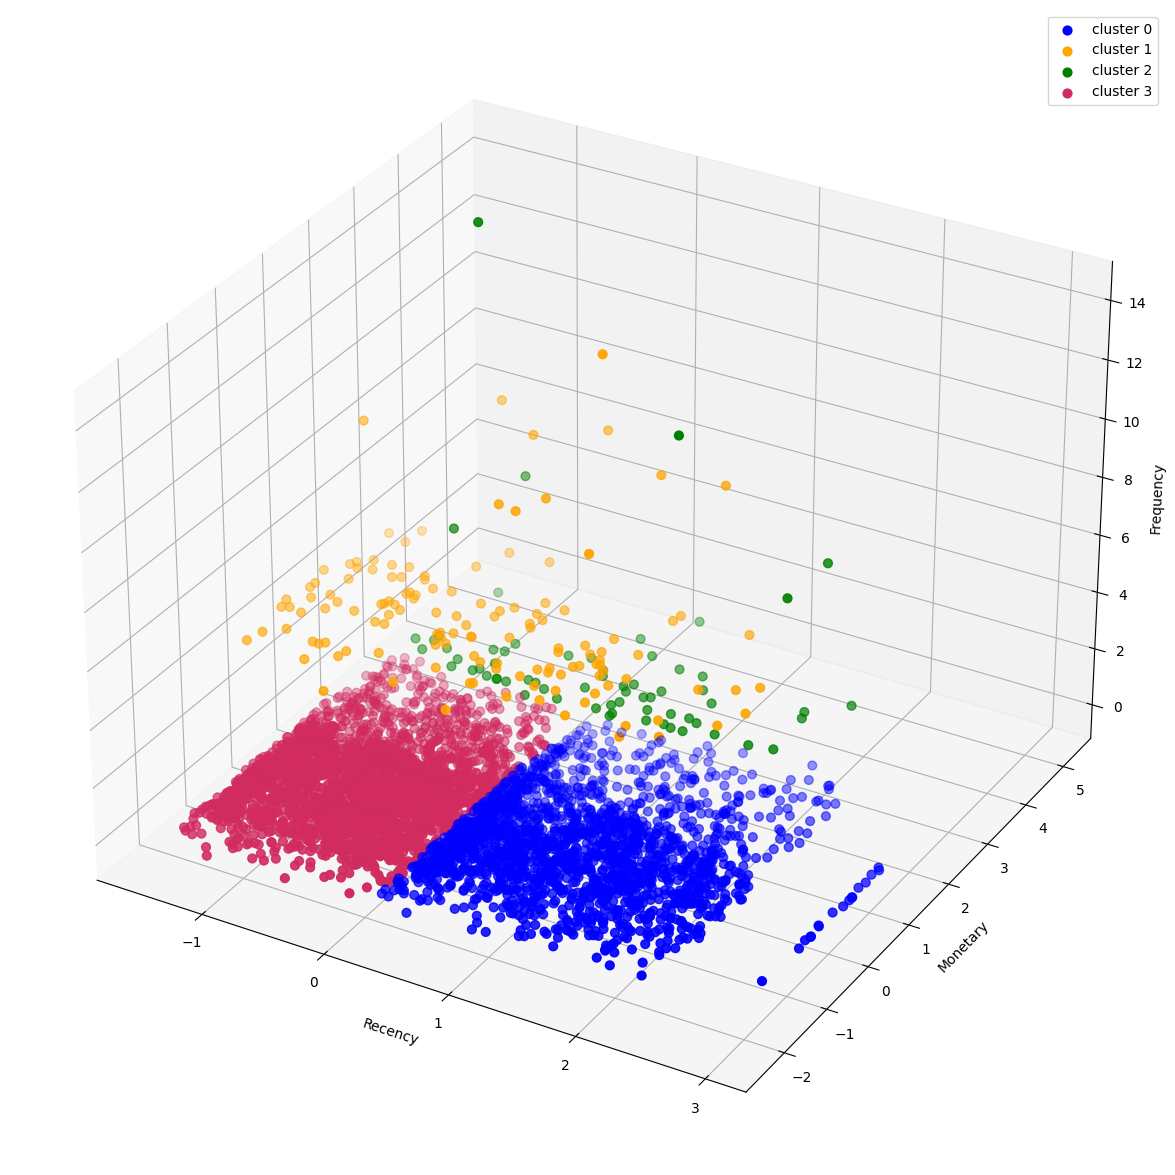

In [62]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y_clusters == 0,0],x[y_clusters == 0,1],x[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],x[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],x[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(x[y_clusters == 3,0],x[y_clusters == 3,1],x[y_clusters == 3,2], s = 40 , color = '#D12B60', label = "cluster 3")
#ax.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],x[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
#ax.scatter(x[y_clusters == 5,0],x[y_clusters == 5,1],x[y_clusters == 5,2], s = 40 , color = 'red', label = "cluster 5")
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency')
ax.legend()
plt.show()

<a id="5"></a>
<font color="darkslateblue" size=+2.5><b>5. Kmean on improved RFM features</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:grey" data-toggle="popover">go to TOC</a>

In [117]:
## New features

In [64]:
New_feat_df = New_feat_df_log.copy()

In [65]:
N_df_expl = New_feat_df.copy()

In [66]:
#data scaling

sc = StandardScaler()
#scaler.fit(rfm_df_log)
df = pd.DataFrame(sc.fit_transform(New_feat_df) , index = New_feat_df.index , columns=New_feat_df.columns)

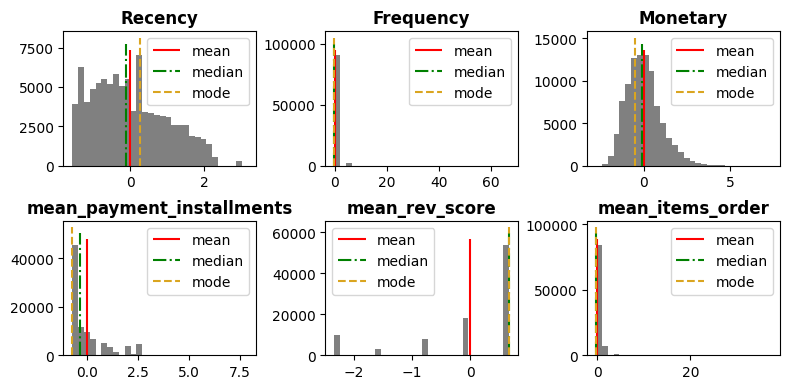

In [67]:
plot_histograms(df=df, cols=df.columns,
                figsize=(8,4), bins=30, color='grey', layout=(2,3))

<a id="5.1"></a>
<font color="dimgrey" size=+2.0><b>5.1 Sampling</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [68]:
## Sampling

In [69]:
# Choosing a model
km_sampl = KMeans(n_clusters=6, init='k-means++', n_init='auto', random_state = 14)
km_sampl.fit(df)

KMeans(n_clusters=6, n_init='auto', random_state=14)

In [70]:
n_iter=10 #10
li_n_samp = [100, 250, 500, 750, 1000, 2000, 3000,
             4000, 5000, 7500, 10000, 20000, 50000]

df_ARI_all_vs_sample_iter = \
    check_ARI_through_sampling(km_sampl, df, li_n_samp,
                               n_iter=n_iter)

ooo ITERATION 0 ooo
ooo ITERATION 1 ooo
ooo ITERATION 2 ooo
ooo ITERATION 3 ooo
ooo ITERATION 4 ooo
ooo ITERATION 5 ooo
ooo ITERATION 6 ooo
ooo ITERATION 7 ooo
ooo ITERATION 8 ooo
ooo ITERATION 9 ooo


In [71]:
# Showing a summary of the ARI scores through iterations
pd.concat([df_ARI_all_vs_sample_iter.mean(1),
           df_ARI_all_vs_sample_iter.std(1), df_ARI_all_vs_sample_iter],
          axis=1).rename(columns={0:'mean', 1: 'std'})

mean           std    iter_0    iter_1    iter_2  \
[all, 100_sampl]    0.732798  0.000000e+00  0.732798  0.732798  0.732798   
[all, 250_sampl]    0.544437  0.000000e+00  0.544437  0.544437  0.544437   
[all, 500_sampl]    0.753449  1.170278e-16  0.753449  0.753449  0.753449   
[all, 750_sampl]    0.857160  0.000000e+00  0.857160  0.857160  0.857160   
[all, 1000_sampl]   0.874893  1.170278e-16  0.874893  0.874893  0.874893   
[all, 2000_sampl]   0.906380  0.000000e+00  0.906380  0.906380  0.906380   
[all, 3000_sampl]   0.903620  1.170278e-16  0.903620  0.903620  0.903620   
[all, 4000_sampl]   0.906138  1.170278e-16  0.906138  0.906138  0.906138   
[all, 5000_sampl]   0.908290  0.000000e+00  0.908290  0.908290  0.908290   
[all, 7500_sampl]   0.921573  0.000000e+00  0.921573  0.921573  0.921573   
[all, 10000_sampl]  0.929955  0.000000e+00  0.929955  0.929955  0.929955   
[all, 20000_sampl]  0.942550  0.000000e+00  0.942550  0.942550  0.942550   
[all, 50000_sampl]  0.990904  0.000000e+00  0.990904  0.990904  0.990904   

                      iter_3    iter_4    iter_5    iter_6    iter_7  \
[all, 100_sampl]    0.732798  0.732798  0.732798  0.732798  0.732798   
[all, 250_sampl]    0.544437  0.544437  0.544437  0.544437  0.544437   
[all, 500_sampl]    0.753449  0.753449  0.753449  0.753449  0.753449   
[all, 750_sampl]    0.857160  0.857160  0.857160  0.857160  0.857160   
[all, 1000_sampl]   0.874893  0.874893  0.874893  0.874893  0.874893   
[all, 2000_sampl]   0.906380  0.906380  0.906380  0.906380  0.906380   
[all, 3000_sampl]   0.903620  0.903620  0.903620  0.903620  0.903620   
[all, 4000_sampl]   0.906138  0.906138  0.906138  0.906138  0.906138   
[all, 5000_sampl]   0.908290  0.908290  0.908290  0.908290  0.908290   
[all, 7500_sampl]   0.921573  0.921573  0.921573  0.921573  0.921573   
[all, 10000_sampl]  0.929955  0.929955  0.929955  0.929955  0.929955   
[all, 20000_sampl]  0.942550  0.942550  0.942550  0.942550  0.942550   
[all, 50000_sampl]  0.990904  0.990904  0.990904  0.990904  0.990904   

                      iter_8    iter_9  
[all, 100_sampl]    0.732798  0.732798  
[all, 250_sampl]    0.544437  0.544437  
[all, 500_sampl]    0.753449  0.753449  
[all, 750_sampl]    0.857160  0.857160  
[all, 1000_sampl]   0.874893  0.874893  
[all, 2000_sampl]   0.906380  0.906380  
[all, 3000_sampl]   0.903620  0.903620  
[all, 4000_sampl]   0.906138  0.906138  
[all, 5000_sampl]   0.908290  0.908290  
[all, 7500_sampl]   0.921573  0.921573  
[all, 10000_sampl]  0.929955  0.929955  
[all, 20000_sampl]  0.942550  0.942550  
[all, 50000_sampl]  0.990904  0.990904

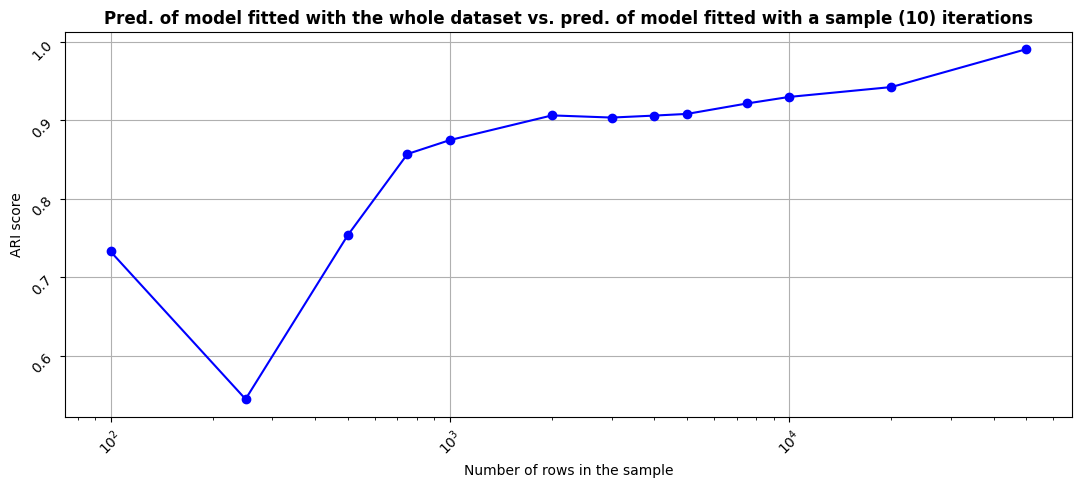

In [72]:
# Plotting the results

fig, ax = plt.subplots(1)
fig.set_size_inches(13,5)

ax.errorbar(li_n_samp,
            df_ARI_all_vs_sample_iter.mean(1).values,
            yerr=2*(df_ARI_all_vs_sample_iter.std(1).values),
            marker='o', color='blue')

ax.tick_params(rotation=45)
ax.set_xscale('log')
plt.xlabel("Number of rows in the sample")
plt.ylabel("ARI score")
plt.title(f"Pred. of model fitted with the whole dataset \
vs. pred. of model fitted with a sample ({n_iter}) iterations", fontweight='bold')
plt.grid()
plt.show()

In [73]:
df_sampl, _ = train_test_split( df, train_size=5000)
ind_sampl = df_sampl.index

In [74]:
df = df.loc[ind_sampl]
N_df_expl = N_df_expl.loc[ind_sampl]

<a id="5.2"></a>
<font color="dimgrey" size=+2.0><b>5.2 Testing the number of clusters</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [75]:
%%time

import dill

# If the results are not existing (pickle) then recomputes
# Returns:
# - the aggregated results (mean, median, std) of the 4 scores
# - the list of the clusters predicted for each iteration and number of clusters
# - the proportion (pct) of the clusters 

list_n_clust = range(3,9)
n_iter = 10
dict_scores_iter, dict_ser_clust_n_clust, dict_pop_perc_n_clust = \
                    compute_clust_scores_nclust(df,
                                                list_n_clust=list_n_clust,
                                                n_iter=n_iter,
                                                return_pop=True)

CPU times: total: 1min 1s
Wall time: 22.5 s


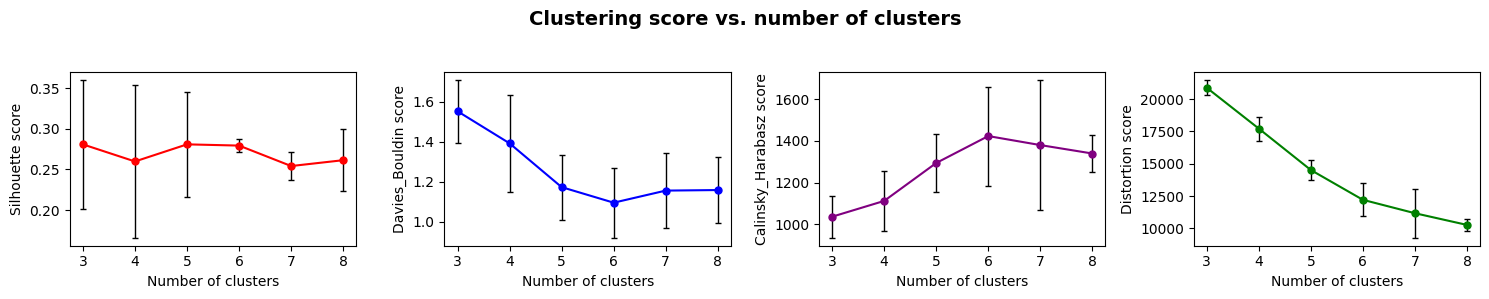

In [76]:
plot_scores_vs_n_clust(dict_scores_iter, figsize=(15,3))

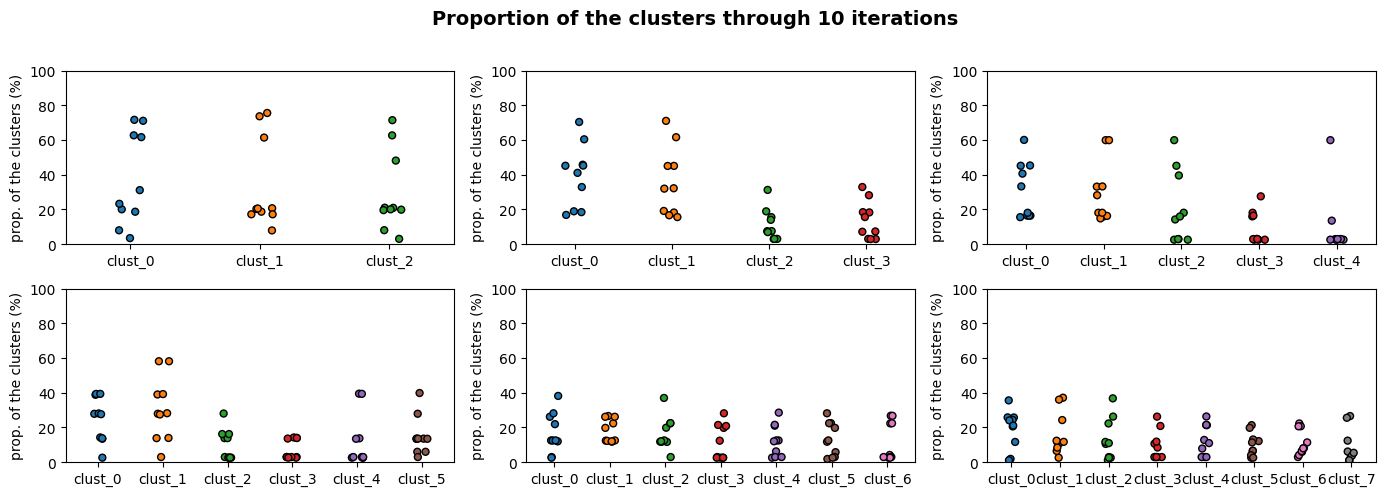

In [77]:
plot_prop_clust_vs_nclust(dict_pop_perc_n_clust, figsize=(14,7))

#### Silhouette scores of each cluster

Let's now see in more details the silhouette scores of each cluster, for the different number of clusters.

On the left part of the graph, the silhouette coefficient is plotted for each number of clusters:
- the length of the bands is proportionnal to the size of the cluster
- the width of the small bars are the distance of each point to the closest centroid

On the right a representation of the clusters on t-SNE projection of the data.

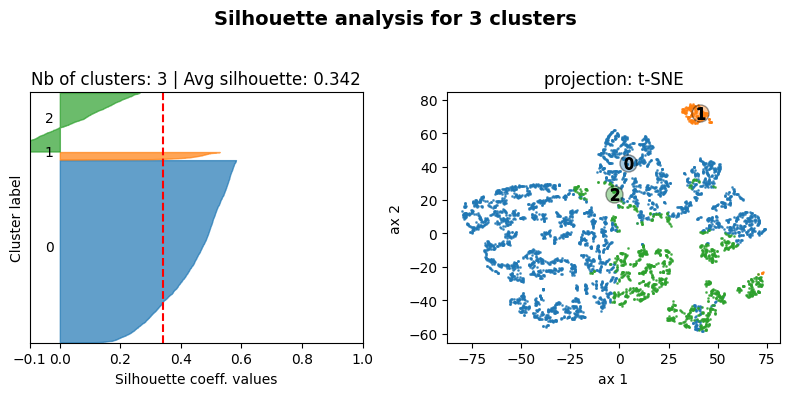

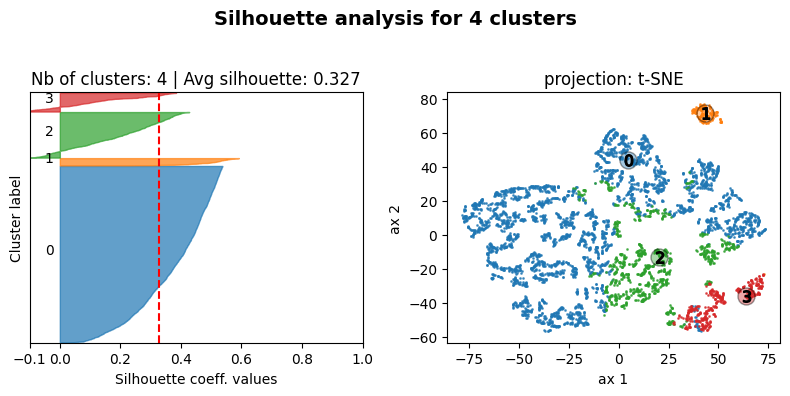

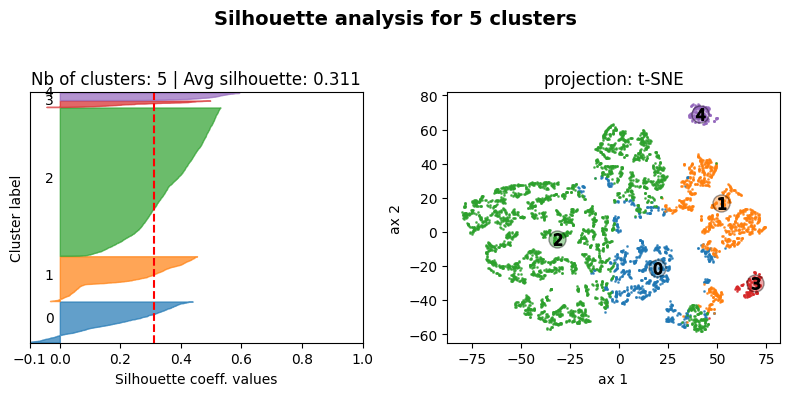

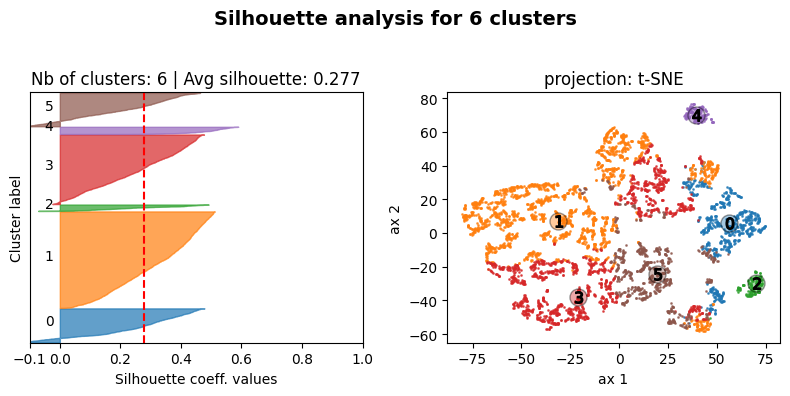

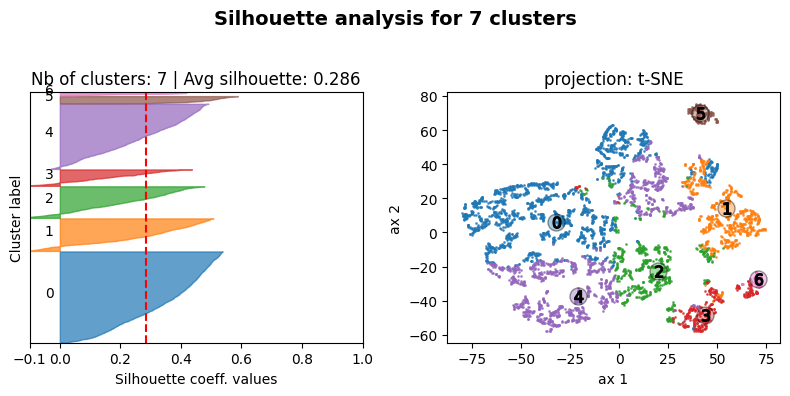

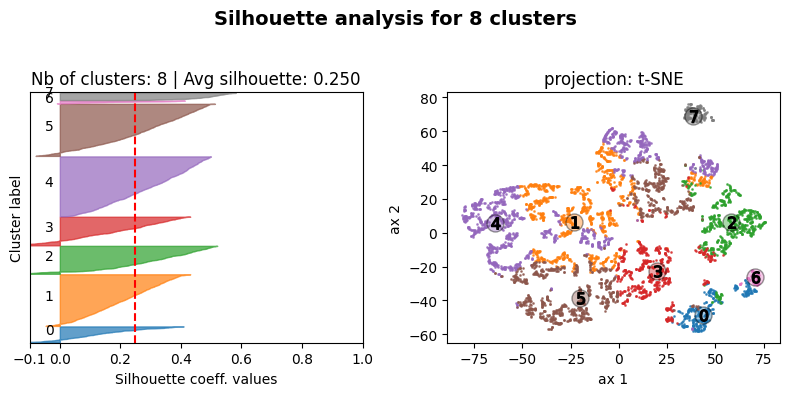

CPU times: total: 14min 55s
Wall time: 2min 22s


In [78]:
%%time

silh_scores_vs_n_clust(df, n_clust=list_n_clust, proj='t-SNE',
                       xlim=(-0.1,1), figsize=(8,4),
                       palette='tab10')

In [79]:
df_ARI_stab = pd.DataFrame()
for i in list_n_clust:
    print("ooooooooo Number of clusters: ", i)
    stab_init_kmeans = ARI_column_pairs(dict_ser_clust_n_clust[i],
                                        first_vs_others=False)
    df_ARI_stab = pd.concat([df_ARI_stab, stab_init_kmeans.to_frame()], axis=1)

ooooooooo Number of clusters:  3
--- ARI all 45 unique pairs ---
ARI: mean=0.536, std=0.255, min=0.068, max=0.999 
ooooooooo Number of clusters:  4
--- ARI all 45 unique pairs ---
ARI: mean=0.551, std=0.228, min=0.238, max=0.999 
ooooooooo Number of clusters:  5
--- ARI all 45 unique pairs ---
ARI: mean=0.621, std=0.244, min=0.404, max=1.000 
ooooooooo Number of clusters:  6
--- ARI all 45 unique pairs ---
ARI: mean=0.792, std=0.258, min=0.443, max=1.000 
ooooooooo Number of clusters:  7
--- ARI all 45 unique pairs ---
ARI: mean=0.808, std=0.195, min=0.526, max=1.000 
ooooooooo Number of clusters:  8
--- ARI all 45 unique pairs ---
ARI: mean=0.687, std=0.160, min=0.462, max=0.994 


In [80]:
df_ARI_stab.sample(3)

ARI_3_clust_all_pairs  ARI_4_clust_all_pairs  \
[iter_3, iter_5]               0.604386               0.358896   
[iter_2, iter_6]               0.385024               0.335795   
[iter_5, iter_9]               0.136772               0.400454   

                  ARI_5_clust_all_pairs  ARI_6_clust_all_pairs  \
[iter_3, iter_5]               0.994357               0.443216   
[iter_2, iter_6]               0.448235               0.968439   
[iter_5, iter_9]               1.000000               0.443173   

                  ARI_7_clust_all_pairs  ARI_8_clust_all_pairs  
[iter_3, iter_5]               0.565610               0.564329  
[iter_2, iter_6]               0.983837               0.991731  
[iter_5, iter_9]               0.941209               0.793718

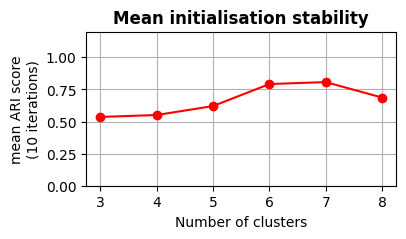

In [81]:
fig, ax = plt.subplots(1)
fig.set_size_inches(4,2)
ax.plot(list_n_clust, df_ARI_stab.mean(), '-or')
ax.set_xlabel('Number of clusters')
ax.set_ylabel(f'mean ARI score\n({n_iter} iterations)')
ax.set(ylim=(0.0,1.2))
ax.grid()
plt.title('Mean initialisation stability', fontweight='bold')
plt.show()

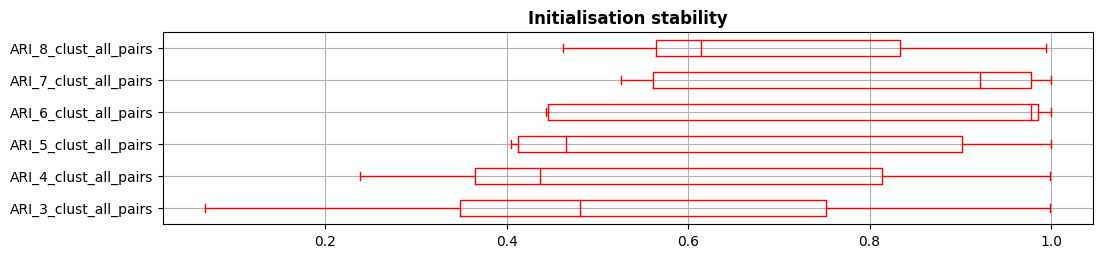

In [82]:
df_ARI_stab.boxplot(color='red', vert=False)
plt.gcf().set_size_inches(12,2.5)
plt.title('Initialisation stability', fontweight='bold')
plt.show()

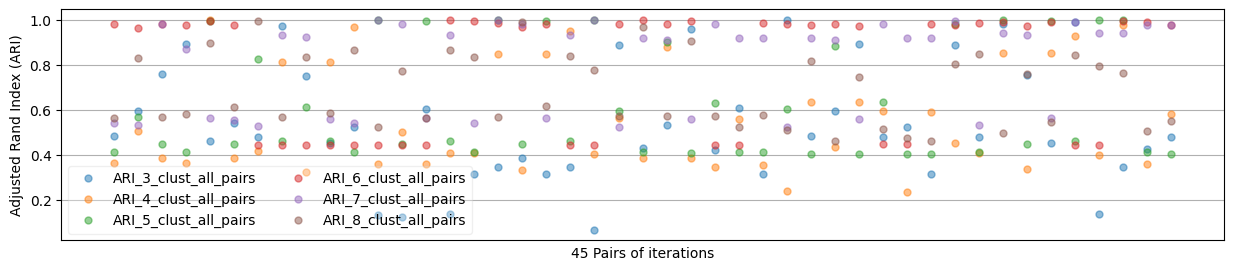

In [83]:
fig, ax = plt.subplots(1)
df_ARI_stab.plot(marker='o', markersize=5, linestyle='', alpha=0.5, ax=ax)
fig.set_size_inches(15,3)
ax.legend(ncol=2).get_frame().set_alpha(0.3)
ax.set_ylabel('Adjusted Rand Index (ARI)')
ax.set_xlabel(f'{df_ARI_stab.shape[0]} Pairs of iterations')
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.grid(axis='y')
plt.show()

<a id="5.3"></a>
<font color="dimgrey" size=+2.0><b>5.3 Clusters Analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [84]:
# fit the model on the whole dataframe

n_clust = 6
best_model = KMeans(n_clusters=n_clust, n_init='auto',init='k-means++', random_state = 14) #n_jobs deprecated
best_model.fit(df)
ser_clust = pd.Series(data=best_model.labels_,
                      index=df.index)

silh = silhouette_score(X=df, labels=ser_clust)
dav_bould = davies_bouldin_score(X=df, labels=ser_clust)
cal_harab = calinski_harabasz_score(X=df, labels=ser_clust)
distor = best_model.inertia_
silh, cal_harab, dav_bould, distor

(0.2773806800791938,
 1479.3055349605345,
 1.0521794319312299,
 11900.905721018522)

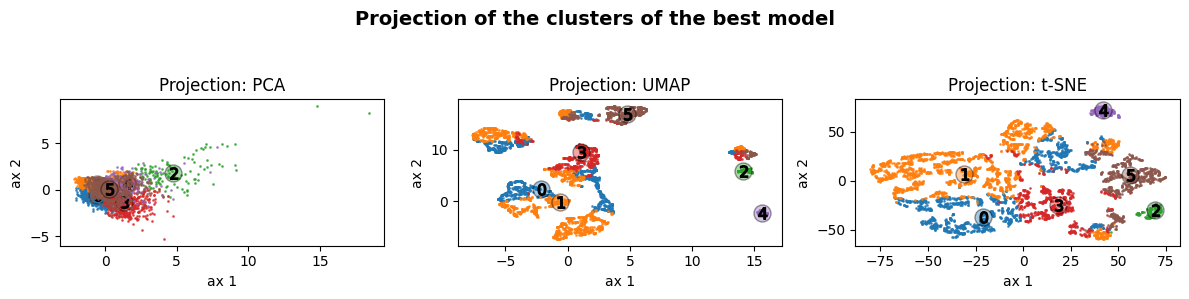

In [85]:
fig = plt.figure(figsize=(12,3))

tab_proj = ['PCA', 'UMAP', 't-SNE']
for i, proj in enumerate(tab_proj,1):
    ax = fig.add_subplot(1,len(tab_proj), i)
    # plot only a sample, but using the model already fitted
    plot_projection(df, model=best_model, proj=proj,
                    fig=fig, ax=ax)

fig.suptitle("Projection of the clusters of the best model",
            fontweight='bold', fontsize=14)
fig.tight_layout(rect=[0,0,1,0.92])
plt.show()

#### Contingency table, Chi square scores (clusters vs. binarized features)

In [86]:
best_model.fit(df)
ser_clust = pd.Series(best_model.labels_,
                        index=df.index,
                        name='clust')
df_expl_quant = N_df_expl.select_dtypes(include=[np.number])
ser_bin = pd.qcut(df_expl_quant[df_expl_quant.columns[0]],
                  [0,0.2,0.4,0.6,0.8,1],
                  precision=2, duplicates='drop')


data_crosstab = pd.crosstab(ser_clust, ser_bin, margins = False)

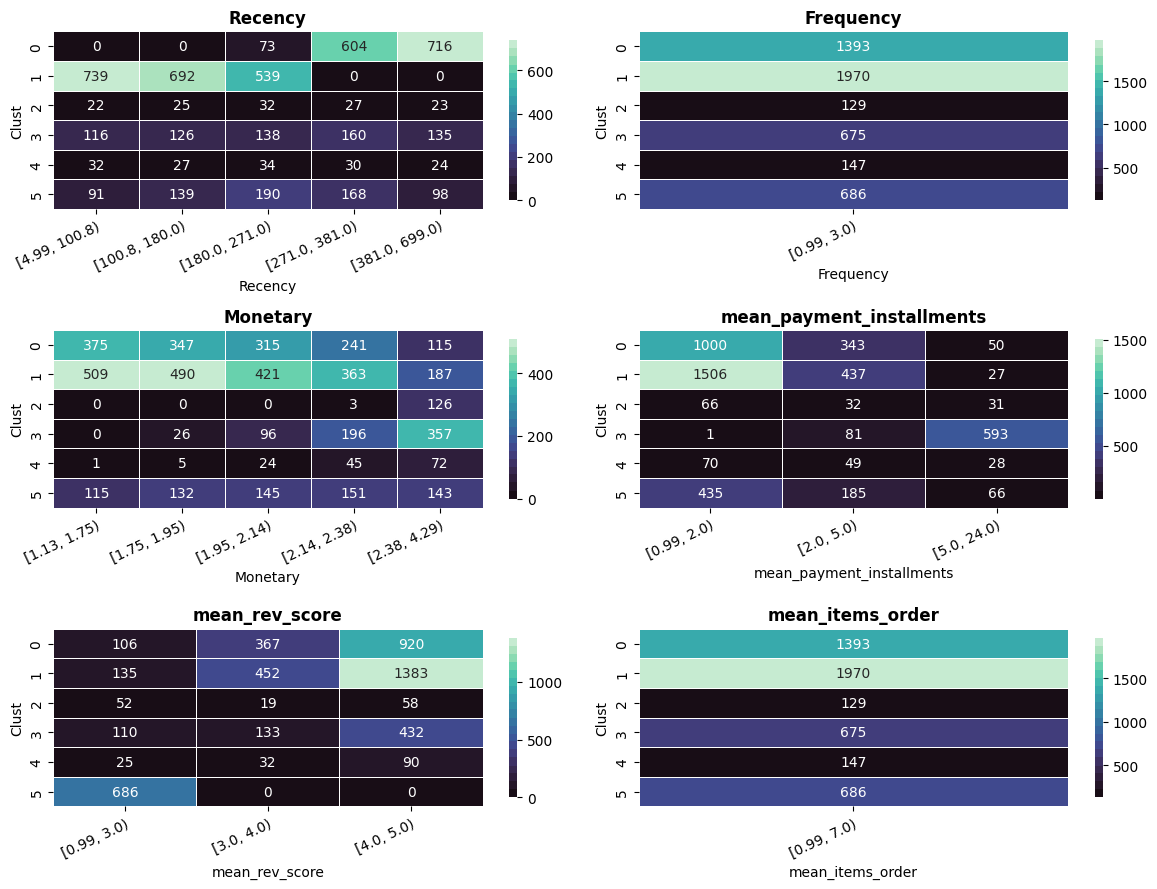

In [87]:
contingency_tables(best_model, df, N_df_expl, palette="mako",
                   cut_mode='quantile')

#### Relative difference of the mean

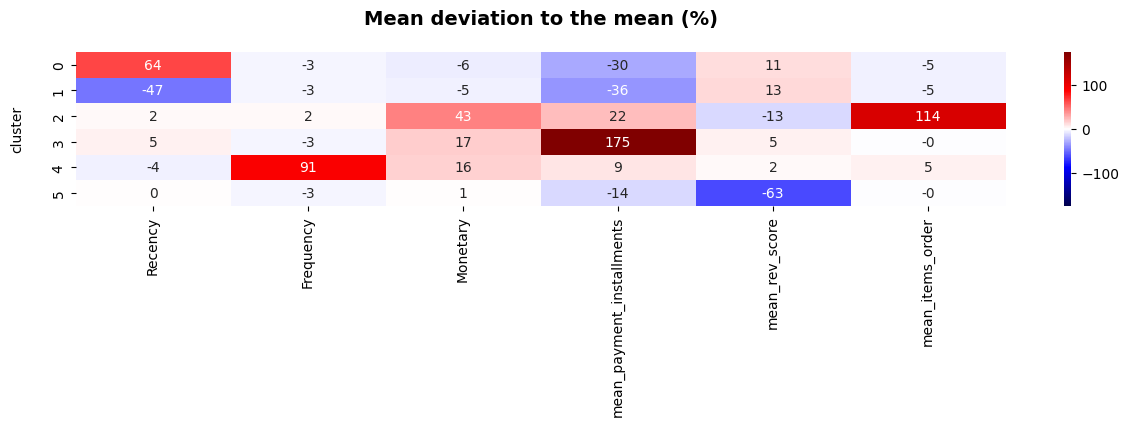

In [88]:
clust_mean, orig_df_mean, rel_var = mean_deviation_clust(best_model, df,
                                                         N_df_expl.loc[df.index],
                                                         palette='seismic',
                                                         figsize=(15,2))

In [89]:
# ANOVA and Kruskal-Wallis for each features against clusters

Anova_Kruskal_df = pd.DataFrame()
for i, col in enumerate(N_df_expl.columns,1):
    ser = test_distrib_clust(N_df_expl.assign(clust=ser_clust), col,
                       'clust', print_opt=False)
    Anova_Kruskal_df = pd.concat([Anova_Kruskal_df, ser.to_frame()], axis=1)

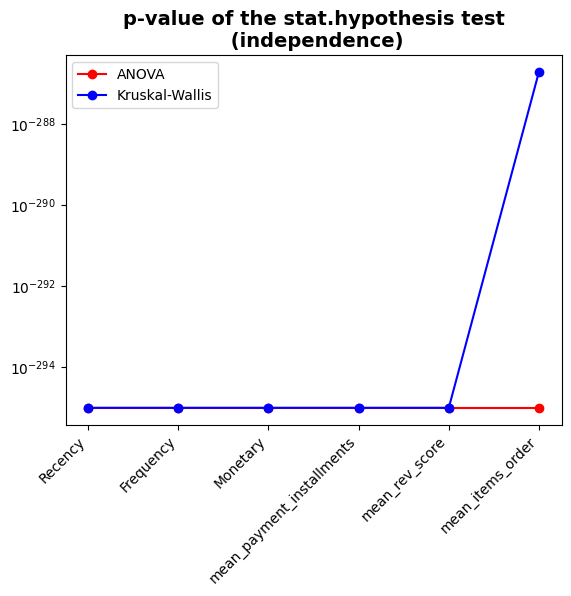

Axes(0.125,0.11;0.775x0.77)


In [90]:
fig, ax = plt.subplots(1)

ser_anova = pd.Series([a for a,b in Anova_Kruskal_df.loc['ANOVA'].values],
          index = Anova_Kruskal_df.loc['ANOVA'].index,
          name='anova')
ser_kruskal = pd.Series([a for a,b in Anova_Kruskal_df.loc['Kruskal-Wallis'].values],
          index = Anova_Kruskal_df.loc['Kruskal-Wallis'].index,
          name='kruskal')
df_ = pd.concat([ser_anova, ser_kruskal], axis=1).sort_values('anova')

(df_['anova'].sort_values()+1e-295).plot(marker='o', color='red',
                                         label='ANOVA', ax=ax)
(df_['kruskal'].sort_values()+1e-295).plot(marker='o', color='blue',
                                           label='Kruskal-Wallis', ax=ax)

ax.set_yscale('log')
ax.set_xticks(np.arange(ser_anova.shape[0]))
ax.set_xticklabels(df_.index)
plt.xticks(rotation=45, ha='right')
#plt.xticks(np.arange(ser_anova.shape[0]))
plt.title('p-value of the stat.hypothesis test\n (independence)',
          fontweight='bold', fontsize='14')
plt.legend()
plt.show()
print(ax)

#### Boxplots and histograms

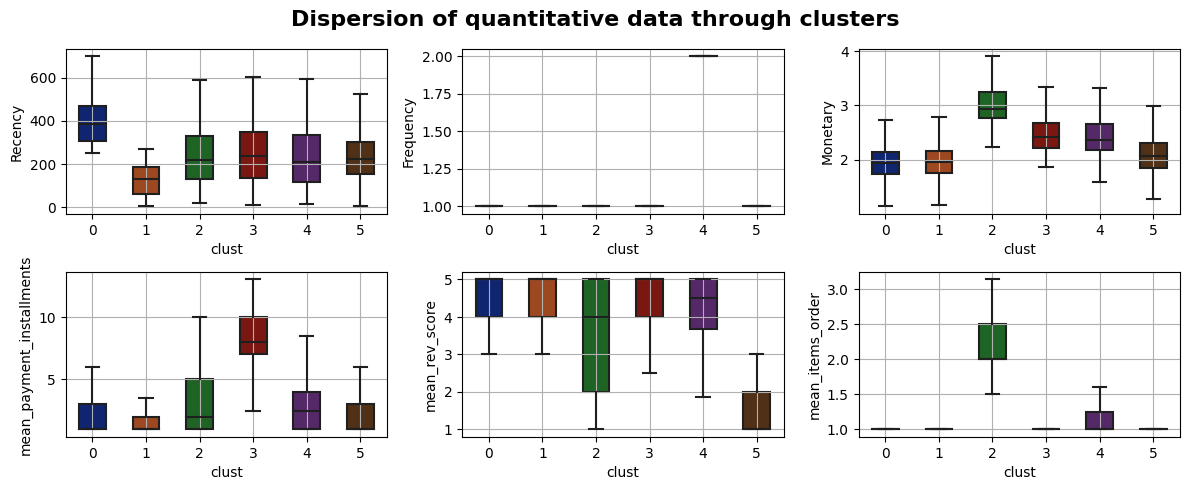

In [91]:
plot_dist_plots_feat_vs_clust(df, N_df_expl, best_model, layout=(3,3),
                              figsize=(12,7),col_order=df_.index)

In [93]:
ser_clust = best_model.labels_
ser_mean = N_df_expl.mean()
ser_median = N_df_expl.median()

# DataFrame with the values of each columns for each cluster centroid
df_centroids = pd.DataFrame(best_model.cluster_centers_,
                            index=pd.Index(range(best_model.cluster_centers_.shape[0]),
                                           name='clust'),
                            columns=df.columns)

# DataFrame with the means of each columns for each cluster
df_clust = N_df_expl.assign(clust=ser_clust)\
    .reindex(columns=['clust']+list(N_df_expl.columns))
df_clust_mean = df_clust.groupby('clust').mean()

# DataFrame with the medians of each columns for each cluster
df_clust = N_df_expl.assign(clust=ser_clust)\
    .reindex(columns=['clust']+list(N_df_expl.columns))
df_clust_median = df_clust.groupby('clust').median()

display(df_clust_mean, df_clust_median, df_centroids)

Recency  Frequency  Monetary  mean_payment_installments  \
clust                                                               
0      393.842785   1.000000  1.951562                   1.996530   
1      127.523858   1.000000  1.967997                   1.803553   
2      245.201550   1.046512  3.028893                   3.541528   
3      251.943704   1.000000  2.455217                   8.105185   
4      229.659864   2.061224  2.436084                   3.151895   
5      241.344023   1.000000  2.099232                   2.475462   

       mean_rev_score  mean_items_order  
clust                                    
0            4.583632          1.020818  
1            4.633249          1.024619  
2            3.550388          2.407715  
3            4.334074          1.069630  
4            4.185585          1.125931  
5            1.460641          1.071429

Recency  Frequency  Monetary  mean_payment_installments  \
clust                                                            
0        384.0        1.0  1.939220                        1.0   
1        129.0        1.0  1.950073                        1.0   
2        220.0        1.0  2.944419                        2.0   
3        238.0        1.0  2.411502                        8.0   
4        208.0        2.0  2.366834                        2.5   
5        222.5        1.0  2.073039                        1.0   

       mean_rev_score  mean_items_order  
clust                                    
0                 5.0               1.0  
1                 5.0               1.0  
2                 4.0               2.0  
3                 5.0               1.0  
4                 4.5               1.0  
5                 1.0               1.0

Recency  Frequency  Monetary  mean_payment_installments  \
clust                                                             
0      0.987157  -0.160426 -0.338485                  -0.339422   
1     -0.751620  -0.160426 -0.297258                  -0.411381   
2      0.016689   0.062936  2.364024                   0.236689   
3      0.060708  -0.160426  0.924945                   1.938424   
4     -0.084781   4.935887  0.876949                   0.091400   
5     -0.008496  -0.160426  0.031948                  -0.160834   

       mean_rev_score  mean_items_order  
clust                                    
0            0.361729         -0.186699  
1            0.399181         -0.172401  
2           -0.418195          5.030684  
3            0.173355         -0.003076  
4            0.061271          0.208726  
5           -1.995597          0.003692

#### Cluster population

In [94]:
unique, counts = np.unique(ser_clust, return_counts=True)

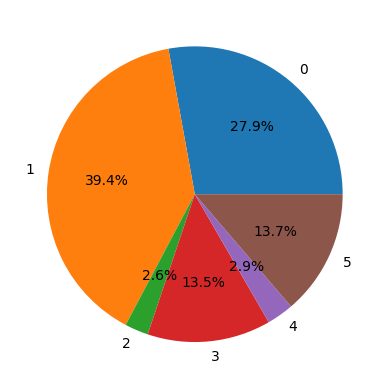

In [96]:
import plotly.express as px

fig, ax = plt.subplots()
ax.pie(counts, labels=unique,autopct='%1.1f%%')
plt.show()

##### Radar chart 

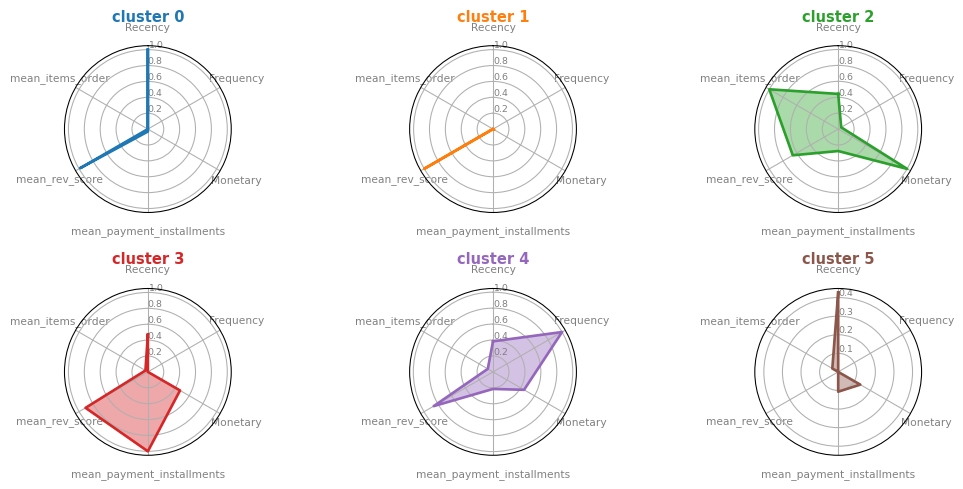

In [97]:
### CENTROIDS
#########################

my_dpi = 96

n_row = (n_clust+1)//2
fig = plt.figure(figsize=(n_row*350/my_dpi, 500/my_dpi),
                dpi=my_dpi)

# Create a color palette:
#my_palette = plt.cm.get_cmap("Dark2", len(df_centroids.index))
my_palette = plt.get_cmap("tab10")

# # Loop to plot
for i, row in enumerate(df_centroids.index, 1):
    ax = fig.add_subplot(2, n_row ,i, polar=True)
    plot_radar_chart(df_centroids, row,
                     title='cluster '+str(row),
                     color= my_palette(row),
                     min_max_scaling=True, ax=ax)
plt.tight_layout()

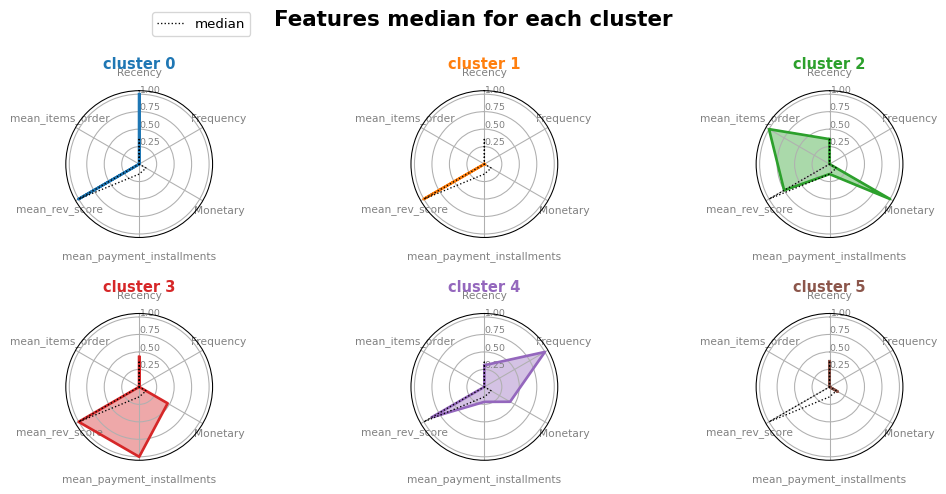

In [98]:
### MEDIAN UNTRANSFORMED DATA
###########################

my_dpi = 96

n_row = (n_clust+1)//2
fig = plt.figure(figsize=(n_row*350/my_dpi, 500/my_dpi),
                dpi=my_dpi)

# Loop to plot
for i, row in enumerate(df_clust_mean.index, 1):
    ax = fig.add_subplot(2,n_row,i, polar=True)
    plot_radar_chart(df_clust_median, row=row, #ser_mean=ser_mean,
                      ser_median=ser_median,
                     title='cluster '+str(row),
                     color=my_palette(row),
                     min_max_scaling=True, ax=ax)
plt.tight_layout(rect=[0,0,1,0.92]) # 
plt.suptitle("Features median for each cluster", fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(-3.4,3.1), ncol=2)
plt.show()

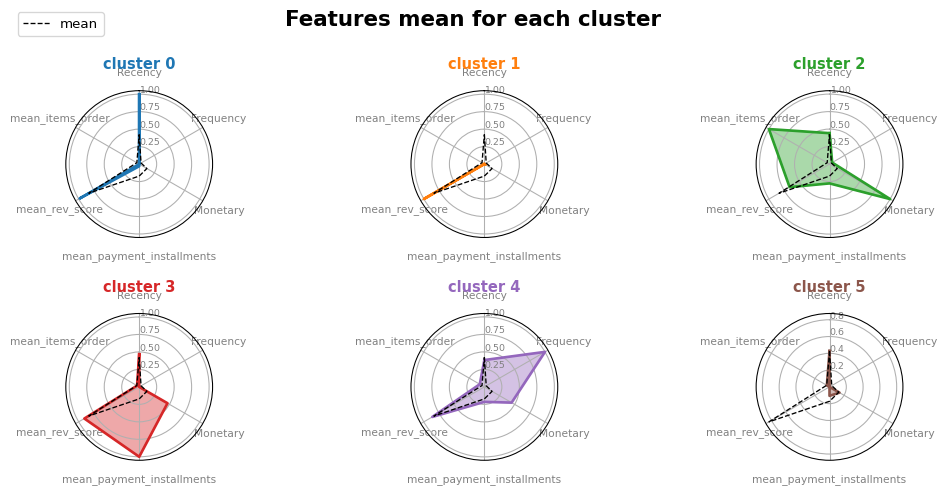

In [99]:
### MEAN UNTRANSFORMED DATA
###########################

my_dpi = 96

n_row = (n_clust+1)//2
fig = plt.figure(figsize=(n_row*350/my_dpi, 500/my_dpi),
                dpi=my_dpi)

# Loop to plot
for i, row in enumerate(df_clust_mean.index, 1):
    ax = fig.add_subplot(2,n_row,i, polar=True)
    plot_radar_chart(df_clust_mean, row=row,
                     ser_mean=ser_mean, #ser_median=ser_median,
                     title='cluster '+str(row),
                     color=my_palette(row),
                     min_max_scaling=True, ax=ax)
plt.tight_layout(rect=[0,0,1,0.92]) # 
plt.suptitle("Features mean for each cluster", fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(-4.4,3.1), ncol=2)
plt.show()

### Cluster interpretation

Cluster 0: old clients, satisfied : __To reactivate__

Cluster 1: New client, satisfied : __Potential loyalist__

Cluster 2: Many product in the same order, large amount, varied review: __Champions__

Cluster 3: large payment installments, large amount, numerous (see cluster population) : __Need Attention__

Cluster 4: recurring customers, satisfied, large amount : __Loyal customers__

Cluster 5: Unhappy customers: __Lost customers__ (population to be monitored)

<a id="6"></a>
<font color="darkslateblue" size=+2.5><b>6. Conclusion</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:grey" data-toggle="popover">go to TOC</a>

We have been able to provide two kind of clustering: RFM and an improved version with client satisfaction, payment installment and number of purchased items added.

The first segmentation (RFM) give standard result and guarantee the marketing team safe result.

On the other hand the improve version by sacrificing little cluster clarity give great clustering segmentation with good new marketing angle to use.

<a id="7"></a>
<font color="darkslateblue" size=+2.5><b>7. Appendix</b></font>

<a id="7.1"></a>
<font color="dimgrey" size=+2.0><b>7.1 DBSCAN</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

This method, as the name suggests, builds clusters based on density.

MinPts and Eps are the hyperparameters (while k is the hyperparameter of kmeans).
MinPts refers to the minimum neighbors within eps radius of neighborhood.
We can make a educated guess of MinPts based on dataset and problem domain knowledge. But eps, related to the radio of clusters, can be choosen with some help: the k-distance graph. Unfortunatly, I couldn't run it here enough to get good results so I made educated guesses here too.

How this algorithm works? Basically, points are classified in core (neighbors>=MinPoints), border (neighbors < MinPoints but is neighbor of some core point) or outlier.
The separation made is like dense regions being separated by low density regions.

DBSCAN can find differents shapes of clusters and, it can find outliers (not all points have to be assign to a cluster). Outliers are classified with the number -1.

In [101]:
RFM_Table = New_feat_df_log[['Recency','Frequency','Monetary']].copy()

In [102]:
# data scaling
scaler = StandardScaler()
#scaler.fit(rfm_df_log)
RFM_Table_scaled = pd.DataFrame(scaler.fit_transform(RFM_Table) , index = RFM_Table.index , columns=RFM_Table.columns)

In [103]:
# fit the model on the whole dataframe

n_clust = 4
best_model = DBSCAN(eps=0.2, min_samples=20, metric='euclidean')
best_model.fit(RFM_Table_scaled)
ser_clust = pd.Series(data=best_model.labels_,
                      index=RFM_Table_scaled.index)

silh = silhouette_score(X=RFM_Table_scaled, labels=ser_clust)
dav_bould = davies_bouldin_score(X=RFM_Table_scaled, labels=ser_clust)
cal_harab = calinski_harabasz_score(X=RFM_Table_scaled, labels=ser_clust)
#distor = best_model.inertia_
silh, cal_harab, dav_bould, distor

(0.4033624226371942, 12005.02782274127, 2.286674340501487, 11900.905721018522)

In [104]:
x = RFM_Table_scaled[['Recency','Monetary','Frequency']].values

In [105]:
y_clusters = best_model.fit_predict(x)

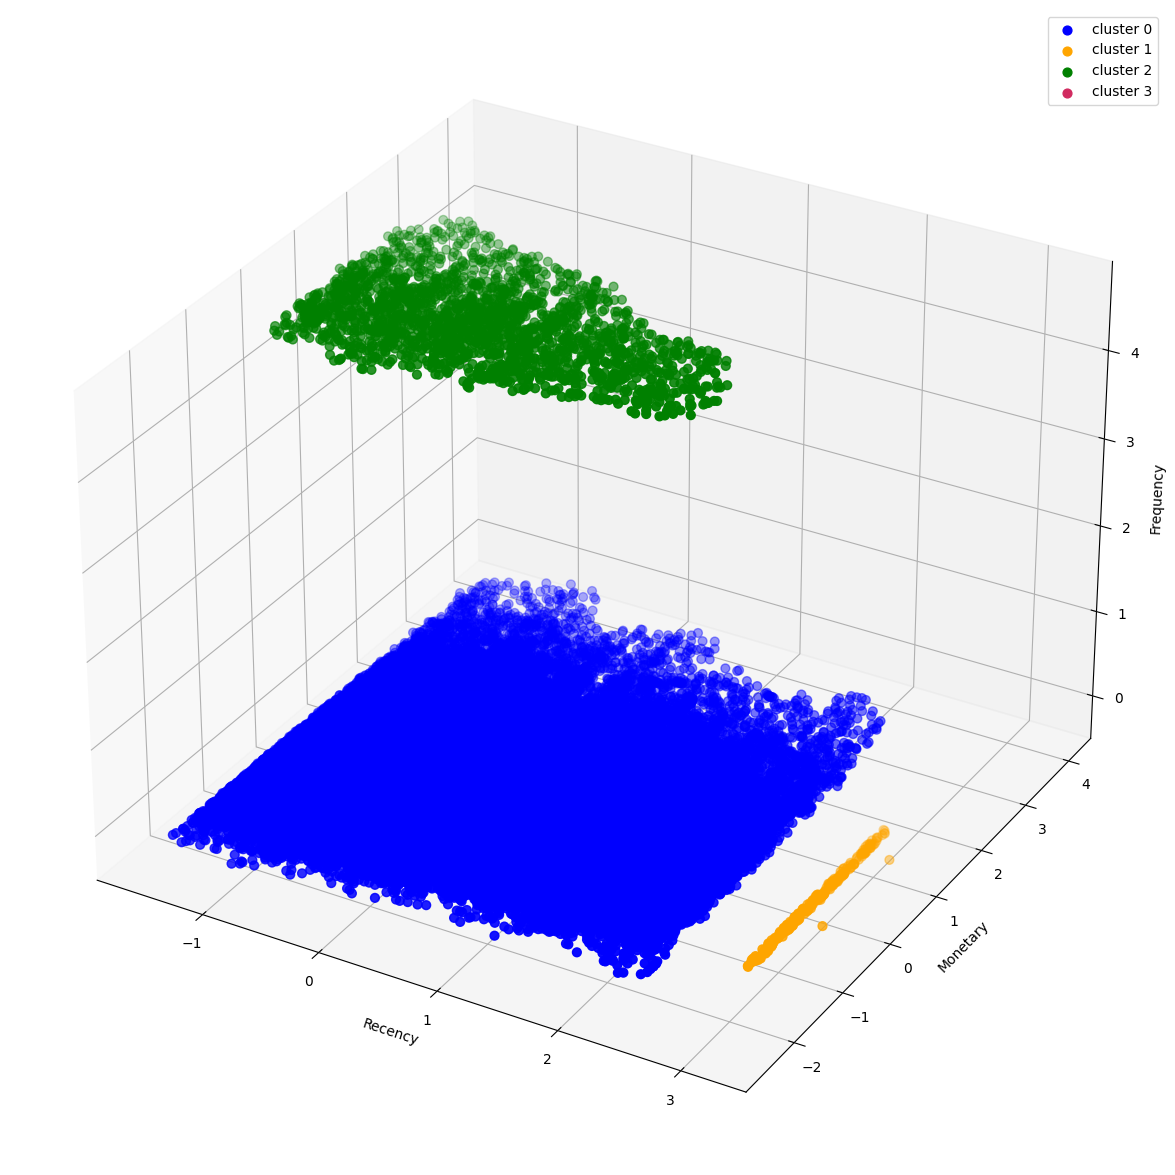

In [106]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y_clusters == 0,0],x[y_clusters == 0,1],x[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],x[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],x[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(x[y_clusters == 3,0],x[y_clusters == 3,1],x[y_clusters == 3,2], s = 40 , color = '#D12B60', label = "cluster 3")
#ax.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],x[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
#ax.scatter(x[y_clusters == 5,0],x[y_clusters == 5,1],x[y_clusters == 5,2], s = 40 , color = 'red', label = "cluster 5")
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency')
ax.legend()
plt.show()

- Unfortunately DBSCAN fail to capture clusters of interest

<a id="7.2"></a>
<font color="dimgrey" size=+2.0><b>7.2 Agglomerative clustering</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [107]:
RFM_Table = New_feat_df_log[['Recency','Frequency','Monetary']].copy()

In [108]:
N_df_expl = New_feat_df.copy()

In [109]:
# data scaling
scaler = StandardScaler()
#scaler.fit(rfm_df_log)
RFM_Table_scaled = pd.DataFrame(scaler.fit_transform(RFM_Table) , index = RFM_Table.index , columns=RFM_Table.columns)

In [110]:
df_sampl, _ = train_test_split(RFM_Table_scaled, train_size=3000)
ind_sampl = df_sampl.index

In [111]:
RFM_Table_scaled = RFM_Table_scaled.loc[ind_sampl]
N_df_expl = New_feat_df.loc[ind_sampl]

In [112]:
'''
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
dfc_h["cluster_hierarchical"] = cluster.fit_predict(dfc_h) 
'''

'\ncluster = AgglomerativeClustering(n_clusters=4, affinity=\'euclidean\', linkage=\'ward\')\ndfc_h["cluster_hierarchical"] = cluster.fit_predict(dfc_h) \n'

In [113]:
# fit the model on the whole dataframe

n_clust = 4
best_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward',)
best_model.fit(RFM_Table_scaled)
ser_clust = pd.Series(data=best_model.labels_,
                      index=RFM_Table_scaled.index)

silh = silhouette_score(X=RFM_Table_scaled, labels=ser_clust)
dav_bould = davies_bouldin_score(X=RFM_Table_scaled, labels=ser_clust)
cal_harab = calinski_harabasz_score(X=RFM_Table_scaled, labels=ser_clust)
#distor = best_model.inertia_
silh, cal_harab, dav_bould, distor


(0.34174697485843253,
 1854.5691100160197,
 0.8683626374720558,
 11900.905721018522)

In [114]:
x = RFM_Table_scaled[['Recency','Monetary','Frequency']].values

In [115]:
y_clusters = best_model.fit_predict(x)

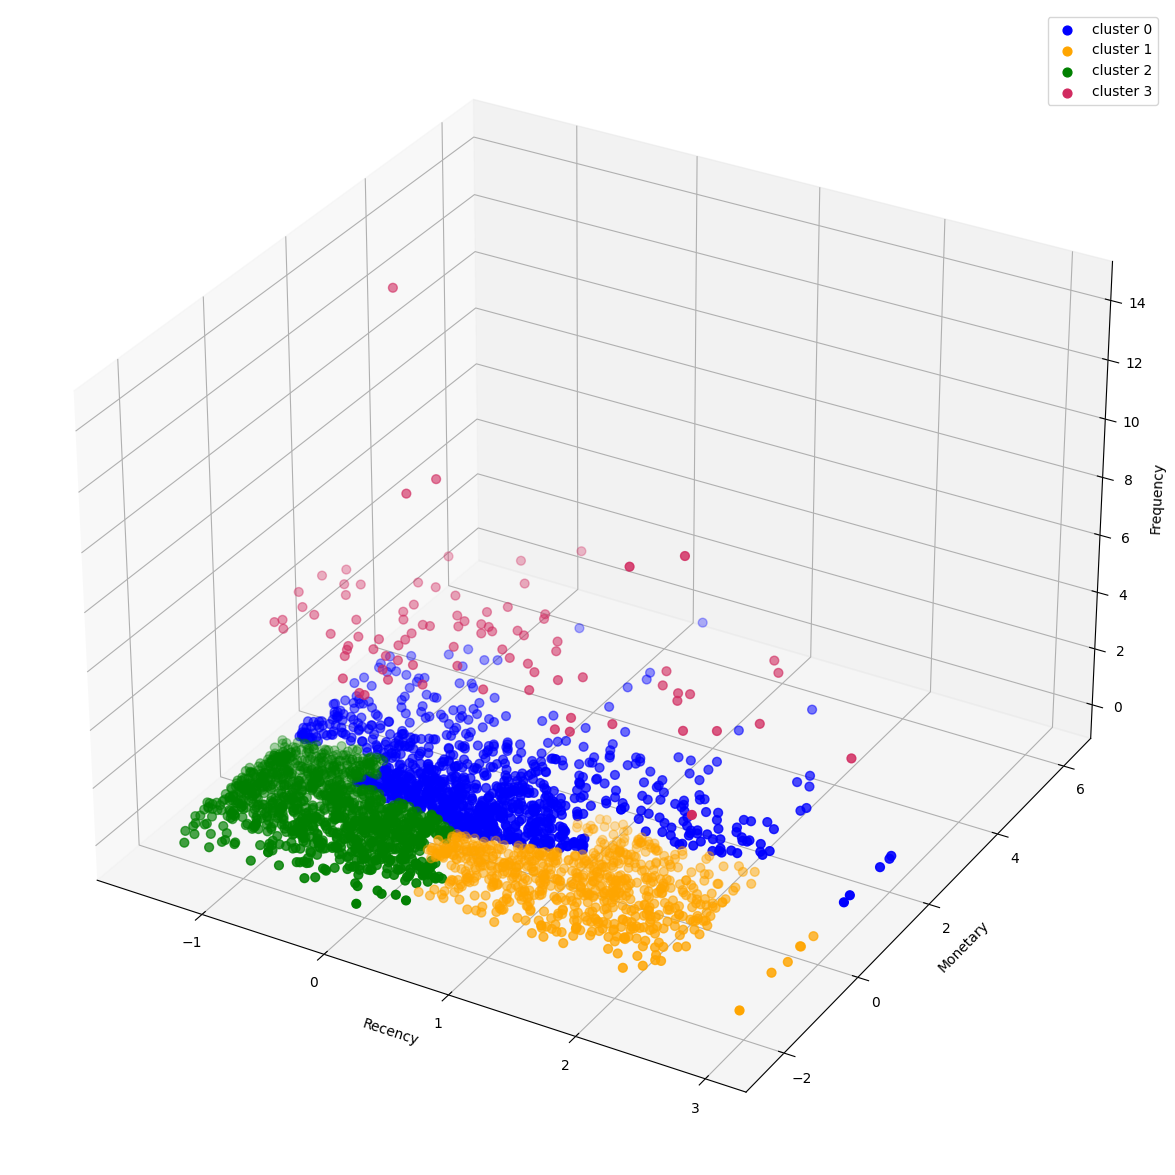

In [116]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y_clusters == 0,0],x[y_clusters == 0,1],x[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],x[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],x[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(x[y_clusters == 3,0],x[y_clusters == 3,1],x[y_clusters == 3,2], s = 40 , color = '#D12B60', label = "cluster 3")
#ax.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],x[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
#ax.scatter(x[y_clusters == 5,0],x[y_clusters == 5,1],x[y_clusters == 5,2], s = 40 , color = 'red', label = "cluster 5")
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency')
ax.legend()
plt.show()

- Result are similar to kmean without being better
  
- We have to work on very small sample to lower computational time which is very problematic